## Imports

In [3]:
import math
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from my_ecog_utils import read_with_annotations, get_multitaper_power_bands

## Power Calcs

In [29]:
pts_w_any_stim = [100, 103, 105, 106, 109, 110, 111, 112, 113, 115]
freqs = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

results_before_after = pd.DataFrame(columns=['ID', 'Stim', 'Trial', 'Channel', 'Delta', 'Theta', 'Alpha', 'Beta', 'Gamma'])
results_before_after.loc[:,'Stim'] = results_before_after['Stim'].astype('bool')

for pt_num in pts_w_any_stim:
    raw = read_with_annotations(pt_num)
    if pt_num in [100, 103, 112, 115]:
        raw.load_data()
        raw.notch_filter(62.5)

    evts, event_id = mne.events_from_annotations(raw, {'BAD_': 0, 'post_shock': 2, 'pre_shock': 1})
    epochs = mne.Epochs(raw, evts, event_id=event_id, tmin=0, tmax=1, baseline=(0.5,1.0))

    if pt_num == 100:
        epochs.rename_channels({'Hip1 - Hip2': 'LHip1 - LHip2', 'Hip3 - Hip4': 'LHip3 - LHip4'})
    elif pt_num == 113:
        epochs.rename_channels(lambda s: s.replace('H', 'Hip'))

    # drop segments that overlap with shocks
    # i.e. those that are shorter than 1 second. May change tmax in the future
    epochs.drop_bad()
    
    # if you ever need to debug, look at the drop logs
    print(epochs.drop_log)
    trial_num = 0
    epoch_num = 0
    shock_num = 1
    for i in range(len(epochs.drop_log)):
        epoch = epochs[epoch_num]
        shock_num += 1
        if epochs.drop_log[i] == ('BAD_',):
            continue
        is_post_stim = 'post_shock' in epoch.event_id
        if not is_post_stim:
            trial_num += 1
            shock_num = 0
        for chan in epochs.ch_names:
            powers = get_multitaper_power_bands(epoch, picks=chan)
            results_before_after = results_before_after.append({'ID': pt_num, 'Stim': is_post_stim, 'Trial': trial_num, 'Channel': chan, 'Stim_Num': shock_num, **powers}, ignore_index=True)
        epoch_num += 1

results_before_after.to_csv('each_stim_before_after.csv', index=False)
results_before_after

((), (), (), (), (), (), (), (), (), (), (), (), (), (), ())
((), (), (), (), (), (), ('BAD_',), (), (), (), (), (), ('BAD_',), (), (), (), ())
((), (), (), (), (), (), (), (), (), (), (), (), (), (), ())
((), (), (), (), (), (), (), ('BAD_',), (), (), (), (), (), ('BAD_',), ())
((), (), (), (), (), (), (), (), (), (), (), (), (), (), ())
((), (), (), (), (), (), (), (), (), (), (), (), (), ())
((), (), (), (), (), (), (), (), (), ())
((), (), (), ('BAD_',), (), (), (), (), (), (), (), (), (), (), ())
((), (), (), (), (), (), (), (), (), (), (), (), (), (), ())


c:\Users\seand\eeg_proj\ecog\my_ecog_utils.py:11: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw.set_annotations(saved_ann)


((), (), (), (), (), (), (), (), (), (), (), (), (), (), ())


ID   Stim Trial        Channel         Delta         Theta  \
0    100  False     1  LHip1 - LHip2  7.676245e-08  7.966128e-08   
1    100  False     1  LHip3 - LHip4  7.599882e-08  5.435899e-08   
2    100  False     1  LatT1 - LatT2  1.777491e-09  1.945915e-09   
3    100  False     1  LatT3 - LatT4  1.063224e-08  1.579306e-08   
4    100   True     1  LHip1 - LHip2  1.142425e-07  7.161263e-08   
..   ...    ...   ...            ...           ...           ...   
559  115   True     3  RHip3 - RHip4  9.366525e-08  3.898334e-08   
560  115   True     3  LHip1 - LHip2  7.930484e-08  3.846025e-08   
561  115   True     3  LHip3 - LHip4  2.255593e-08  1.187012e-08   
562  115   True     3  RHip1 - RHip2  9.711323e-08  5.704873e-08   
563  115   True     3  RHip3 - RHip4  9.523928e-08  4.836225e-08   

            Alpha          Beta         Gamma  Stim_Num  
0    3.897899e-08  1.350653e-08  8.706455e-10       0.0  
1    7.955522e-09  3.615457e-09  4.294396e-10       0.0  
2    7.836614e-10  2.448647e-10  3.852345e-11       0.0  
3    8.962653e-09  1.447087e-09  1.441858e-10       0.0  
4    2.537439e-08  1.169223e-08  6.854174e-10       1.0  
..            ...           ...           ...       ...  
559  1.177374e-08  1.676138e-09  2.128235e-10       3.0  
560  8.028031e-09  1.502573e-09  9.435474e-11       4.0  
561  4.359613e-09  1.080279e-09  7.977601e-11       4.0  
562  2.026480e-08  1.892534e-09  1.022950e-10       4.0  
563  8.531949e-09  1.652413e-09  1.153763e-10       4.0  

[564 rows x 10 columns]

In [30]:
results_before_after['Stim_Num'] = results_before_after['Stim_Num'].astype(int)

In [31]:
# ensures that pre-shock is always set to Stim Number 0
assert ((results_before_after['Stim'] != False) & (results_before_after['Stim_Num'] == 0)).sum() == 0

In [32]:
# results_before_after = pd.read_csv('each_stim_before_after.csv')
# results_before_after

In [33]:
baselines = results_before_after[results_before_after['Stim'] == False]
stims = results_before_after[results_before_after['Stim'] == True]
rearranged = stims.merge(baselines, on=['ID', 'Trial', 'Channel'], suffixes=['_post', '_pre'])
rearranged = rearranged.drop(['Stim_post', 'Stim_pre'], axis='columns')
rearranged

ID Trial        Channel    Delta_post    Theta_post    Alpha_post  \
0    100     1  LHip1 - LHip2  1.142425e-07  7.161263e-08  2.537439e-08   
1    100     1  LHip1 - LHip2  5.835947e-08  3.228662e-08  2.086371e-08   
2    100     1  LHip1 - LHip2  5.101078e-08  3.540437e-08  3.576591e-08   
3    100     1  LHip1 - LHip2  8.638911e-08  8.010154e-08  4.598185e-08   
4    100     1  LHip3 - LHip4  3.784396e-07  7.526684e-08  5.945997e-09   
..   ...   ...            ...           ...           ...           ...   
443  115     3  RHip1 - RHip2  9.711323e-08  5.704873e-08  2.026480e-08   
444  115     3  RHip3 - RHip4  1.015564e-07  2.902442e-08  3.397387e-09   
445  115     3  RHip3 - RHip4  3.798705e-08  1.329936e-08  2.844349e-09   
446  115     3  RHip3 - RHip4  9.366525e-08  3.898334e-08  1.177374e-08   
447  115     3  RHip3 - RHip4  9.523928e-08  4.836225e-08  8.531949e-09   

        Beta_post    Gamma_post  Stim_Num_post     Delta_pre     Theta_pre  \
0    1.169223e-08  6.854174e-10              1  7.676245e-08  7.966128e-08   
1    8.328850e-09  7.199653e-10              2  7.676245e-08  7.966128e-08   
2    1.402683e-08  6.067107e-10              3  7.676245e-08  7.966128e-08   
3    9.420390e-09  5.334231e-10              4  7.676245e-08  7.966128e-08   
4    3.396220e-09  4.870411e-10              1  7.599882e-08  5.435899e-08   
..            ...           ...            ...           ...           ...   
443  1.892534e-09  1.022950e-10              4  6.394327e-08  1.257479e-08   
444  1.678384e-09  1.538645e-10              1  5.952048e-08  1.537873e-08   
445  1.064764e-09  1.290604e-10              2  5.952048e-08  1.537873e-08   
446  1.676138e-09  2.128235e-10              3  5.952048e-08  1.537873e-08   
447  1.652413e-09  1.153763e-10              4  5.952048e-08  1.537873e-08   

        Alpha_pre      Beta_pre     Gamma_pre  Stim_Num_pre  
0    3.897899e-08  1.350653e-08  8.706455e-10             0  
1    3.897899e-08  1.350653e-08  8.706455e-10             0  
2    3.897899e-08  1.350653e-08  8.706455e-10             0  
3    3.897899e-08  1.350653e-08  8.706455e-10             0  
4    7.955522e-09  3.615457e-09  4.294396e-10             0  
..            ...           ...           ...           ...  
443  7.871698e-09  1.820777e-09  1.573105e-10             0  
444  4.737987e-09  1.855336e-09  2.623488e-10             0  
445  4.737987e-09  1.855336e-09  2.623488e-10             0  
446  4.737987e-09  1.855336e-09  2.623488e-10             0  
447  4.737987e-09  1.855336e-09  2.623488e-10             0  

[448 rows x 15 columns]

In [34]:
freqs = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
for freq in freqs:
    rearranged[freq+'_pct'] = (rearranged[freq+'_post'] - rearranged[freq+'_pre']) / rearranged[freq+'_pre'] * 100
rearranged

ID Trial        Channel    Delta_post    Theta_post    Alpha_post  \
0    100     1  LHip1 - LHip2  1.142425e-07  7.161263e-08  2.537439e-08   
1    100     1  LHip1 - LHip2  5.835947e-08  3.228662e-08  2.086371e-08   
2    100     1  LHip1 - LHip2  5.101078e-08  3.540437e-08  3.576591e-08   
3    100     1  LHip1 - LHip2  8.638911e-08  8.010154e-08  4.598185e-08   
4    100     1  LHip3 - LHip4  3.784396e-07  7.526684e-08  5.945997e-09   
..   ...   ...            ...           ...           ...           ...   
443  115     3  RHip1 - RHip2  9.711323e-08  5.704873e-08  2.026480e-08   
444  115     3  RHip3 - RHip4  1.015564e-07  2.902442e-08  3.397387e-09   
445  115     3  RHip3 - RHip4  3.798705e-08  1.329936e-08  2.844349e-09   
446  115     3  RHip3 - RHip4  9.366525e-08  3.898334e-08  1.177374e-08   
447  115     3  RHip3 - RHip4  9.523928e-08  4.836225e-08  8.531949e-09   

        Beta_post    Gamma_post  Stim_Num_post     Delta_pre     Theta_pre  \
0    1.169223e-08  6.854174e-10              1  7.676245e-08  7.966128e-08   
1    8.328850e-09  7.199653e-10              2  7.676245e-08  7.966128e-08   
2    1.402683e-08  6.067107e-10              3  7.676245e-08  7.966128e-08   
3    9.420390e-09  5.334231e-10              4  7.676245e-08  7.966128e-08   
4    3.396220e-09  4.870411e-10              1  7.599882e-08  5.435899e-08   
..            ...           ...            ...           ...           ...   
443  1.892534e-09  1.022950e-10              4  6.394327e-08  1.257479e-08   
444  1.678384e-09  1.538645e-10              1  5.952048e-08  1.537873e-08   
445  1.064764e-09  1.290604e-10              2  5.952048e-08  1.537873e-08   
446  1.676138e-09  2.128235e-10              3  5.952048e-08  1.537873e-08   
447  1.652413e-09  1.153763e-10              4  5.952048e-08  1.537873e-08   

        Alpha_pre      Beta_pre     Gamma_pre  Stim_Num_pre   Delta_pct  \
0    3.897899e-08  1.350653e-08  8.706455e-10             0   48.826088   
1    3.897899e-08  1.350653e-08  8.706455e-10             0  -23.973933   
2    3.897899e-08  1.350653e-08  8.706455e-10             0  -33.547214   
3    3.897899e-08  1.350653e-08  8.706455e-10             0   12.540856   
4    7.955522e-09  3.615457e-09  4.294396e-10             0  397.954603   
..            ...           ...           ...           ...         ...   
443  7.871698e-09  1.820777e-09  1.573105e-10             0   51.874039   
444  4.737987e-09  1.855336e-09  2.623488e-10             0   70.624308   
445  4.737987e-09  1.855336e-09  2.623488e-10             0  -36.178182   
446  4.737987e-09  1.855336e-09  2.623488e-10             0   57.366431   
447  4.737987e-09  1.855336e-09  2.623488e-10             0   60.010951   

      Theta_pct   Alpha_pct   Beta_pct  Gamma_pct  
0    -10.103592  -34.902380 -13.432803 -21.274804  
1    -59.470119  -46.474480 -38.334663 -17.306718  
2    -55.556369   -8.243098   3.852210 -30.314838  
3      0.552668   17.965723 -30.253089 -38.732462  
4     38.462539  -25.259507  -6.063876  13.413165  
..          ...         ...        ...        ...  
443  353.675418  157.438772   3.941027 -34.972506  
444   88.730977  -28.294709  -9.537459 -41.351189  
445  -13.521088  -39.967146 -42.610706 -50.805822  
446  153.488706  148.496677  -9.658502 -18.877683  
447  214.474946   80.075404 -10.937258 -56.021803  

[448 rows x 20 columns]

## Graphing

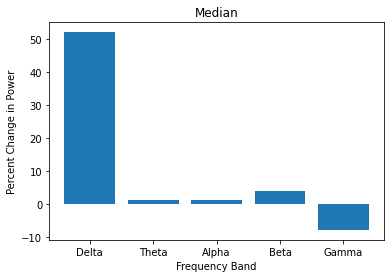

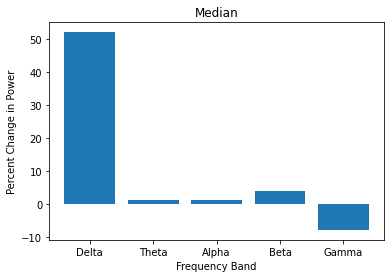

In [35]:
relevant_cols = rearranged.loc[:,'Delta_pct':'Gamma_pct']
fig, ax = plt.subplots()
ax.bar(np.arange(len(freqs)), relevant_cols.median())
ax.set_xticks(np.arange(len(freqs)))
ax.set_xticklabels(freqs)
ax.set_xlabel('Frequency Band')
ax.set_ylabel('Percent Change in Power')
ax.set_title('Median')
fig

This bar graph is a good summary of the data, but I want to get to know my data a bit better, so I'm going to look at a histogram to see more of the individual data points.

(array([396.,  20.,  17.,   7.,   6.,   1.,   0.,   0.,   0.,   1.]),
 array([ -97.94096902,  826.46506142, 1750.87109185, 2675.27712229,
        3599.68315273, 4524.08918317, 5448.4952136 , 6372.90124404,
        7297.30727448, 8221.71330492, 9146.11933535]),
 <BarContainer object of 10 artists>)

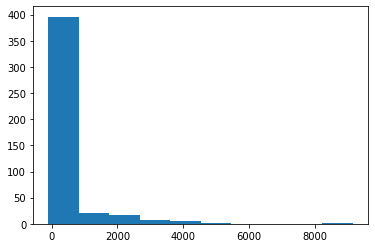

In [36]:
plt.hist(rearranged['Delta_pct'])

Well, this is interesting. There seems to be an outlier where the delta power increased by 10,000% after stimulation. Let's look at the numbers to see if the numbers reflect the graph.

In [37]:
rearranged[rearranged['Delta_pct'] > 10000]

Empty DataFrame
Columns: [ID, Trial, Channel, Delta_post, Theta_post, Alpha_post, Beta_post, Gamma_post, Stim_Num_post, Delta_pre, Theta_pre, Alpha_pre, Beta_pre, Gamma_pre, Stim_Num_pre, Delta_pct, Theta_pct, Alpha_pct, Beta_pct, Gamma_pct]
Index: []

In [38]:
rearranged[(rearranged['ID'] == 113) & (rearranged['Trial'] == 1) & (rearranged['Channel'] == 'RHip1 - RHip2')]['Delta_pct']

360    9146.119335
361    2962.748463
362    2075.516816
363    1813.646994
Name: Delta_pct, dtype: float64

It turns out that there's a good reason why pt 113 has +10,000% delta power in the RHip1 - RHip2 channel. Take a look at the raw voltages in the 3rd channel. I honestly don't think this should be excluded either, it's just an honest outlier.

![](./pt_113_trial_1_plus10k_delta.jpg)

<AxesSubplot:>

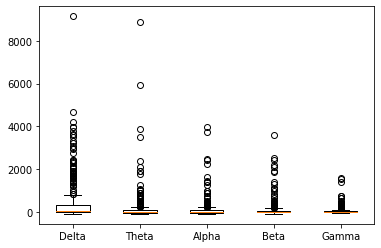

In [39]:
fig, ax = plt.subplots()
ax.boxplot(rearranged.loc[:,'Delta_pct':'Gamma_pct'])
ax.set_xticklabels(freqs)
ax

Even after applying automatic labeling and using the most conservative post-shock periods possible, there are a lot of outliers in the positive direction. This actually makes sense, since power can increase by an infinite amount, but it can only decrease by -100% at the most. We might want to look at a different measurement instead of the percent. Let's try, say, the difference in log(power)

In [40]:
power_log_chg = rearranged.copy()
for freq in freqs:
    power_log_chg = power_log_chg.drop(freq+'_pct', axis=1)
    power_log_chg[freq+'_log_chg'] = np.log10(rearranged[freq+'_post']) - np.log10(rearranged[freq+'_pre'])
power_log_chg = power_log_chg.drop('Stim_Num_pre', axis=1).rename({'Stim_Num_post': 'Stim_Num'}, axis=1)
power_log_chg

ID Trial        Channel    Delta_post    Theta_post    Alpha_post  \
0    100     1  LHip1 - LHip2  1.142425e-07  7.161263e-08  2.537439e-08   
1    100     1  LHip1 - LHip2  5.835947e-08  3.228662e-08  2.086371e-08   
2    100     1  LHip1 - LHip2  5.101078e-08  3.540437e-08  3.576591e-08   
3    100     1  LHip1 - LHip2  8.638911e-08  8.010154e-08  4.598185e-08   
4    100     1  LHip3 - LHip4  3.784396e-07  7.526684e-08  5.945997e-09   
..   ...   ...            ...           ...           ...           ...   
443  115     3  RHip1 - RHip2  9.711323e-08  5.704873e-08  2.026480e-08   
444  115     3  RHip3 - RHip4  1.015564e-07  2.902442e-08  3.397387e-09   
445  115     3  RHip3 - RHip4  3.798705e-08  1.329936e-08  2.844349e-09   
446  115     3  RHip3 - RHip4  9.366525e-08  3.898334e-08  1.177374e-08   
447  115     3  RHip3 - RHip4  9.523928e-08  4.836225e-08  8.531949e-09   

        Beta_post    Gamma_post  Stim_Num     Delta_pre     Theta_pre  \
0    1.169223e-08  6.854174e-10         1  7.676245e-08  7.966128e-08   
1    8.328850e-09  7.199653e-10         2  7.676245e-08  7.966128e-08   
2    1.402683e-08  6.067107e-10         3  7.676245e-08  7.966128e-08   
3    9.420390e-09  5.334231e-10         4  7.676245e-08  7.966128e-08   
4    3.396220e-09  4.870411e-10         1  7.599882e-08  5.435899e-08   
..            ...           ...       ...           ...           ...   
443  1.892534e-09  1.022950e-10         4  6.394327e-08  1.257479e-08   
444  1.678384e-09  1.538645e-10         1  5.952048e-08  1.537873e-08   
445  1.064764e-09  1.290604e-10         2  5.952048e-08  1.537873e-08   
446  1.676138e-09  2.128235e-10         3  5.952048e-08  1.537873e-08   
447  1.652413e-09  1.153763e-10         4  5.952048e-08  1.537873e-08   

        Alpha_pre      Beta_pre     Gamma_pre  Delta_log_chg  Theta_log_chg  \
0    3.897899e-08  1.350653e-08  8.706455e-10       0.172679      -0.046258   
1    3.897899e-08  1.350653e-08  8.706455e-10      -0.119037      -0.392225   
2    3.897899e-08  1.350653e-08  8.706455e-10      -0.177487      -0.352190   
3    3.897899e-08  1.350653e-08  8.706455e-10       0.051310       0.002394   
4    7.955522e-09  3.615457e-09  4.294396e-10       0.697190       0.141332   
..            ...           ...           ...            ...            ...   
443  7.871698e-09  1.820777e-09  1.573105e-10       0.181484       0.656745   
444  4.737987e-09  1.855336e-09  2.623488e-10       0.232041       0.275843   
445  4.737987e-09  1.855336e-09  2.623488e-10      -0.195031      -0.063090   
446  4.737987e-09  1.855336e-09  2.623488e-10       0.196912       0.403959   
447  4.737987e-09  1.855336e-09  2.623488e-10       0.204150       0.497586   

     Alpha_log_chg  Beta_log_chg  Gamma_log_chg  
0        -0.186435     -0.062647      -0.103886  
1        -0.271439     -0.209959      -0.082530  
2        -0.037361      0.016416      -0.156860  
3         0.071756     -0.156475      -0.212770  
4        -0.126444     -0.027167       0.054663  
..             ...           ...            ...  
443       0.410674      0.016787      -0.186903  
444      -0.144449     -0.043531      -0.231741  
445      -0.221611     -0.241169      -0.308086  
446       0.395321     -0.044113      -0.090860  
447       0.255454     -0.050304      -0.356763  

[448 rows x 19 columns]

In [41]:
power_log_chg.to_csv('power_log_chg.csv', index=False)

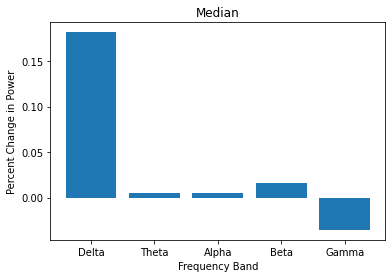

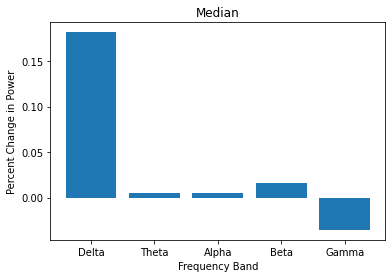

In [42]:
relevant_cols = power_log_chg.loc[:,'Delta_log_chg':'Gamma_log_chg']
fig, ax = plt.subplots()
ax.bar(np.arange(len(freqs)), relevant_cols.median())
ax.set_xticks(np.arange(len(freqs)))
ax.set_xticklabels(freqs)
ax.set_xlabel('Frequency Band')
ax.set_ylabel('Percent Change in Power')
ax.set_title('Median')
fig

Huh, same exact shape as the percent changes. I probably should have expected that. What about the boxplot?

<AxesSubplot:>

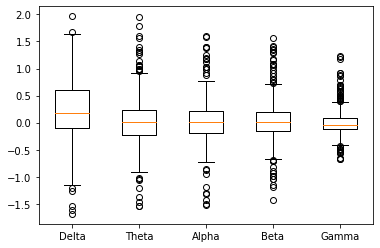

In [43]:
fig, ax = plt.subplots()
ax.boxplot(power_log_chg.loc[:,'Delta_log_chg':'Gamma_log_chg'])
ax.set_xticklabels(freqs)
ax

Okay, so it *does* make a difference on the boxplot. Now we have a much more even distribution of positive and negative changes, which lets us see more clearly that there doesn't seem to be a huge change in the power immediately after stimulation. Well, that's boring. Is the whole project dead in the water here? I suppose we could still try stratifying based on channel/location. And we can also look at each individual patient to see if some people consistently react positively and others consistently react negatively. Let's start by looking at the boxplots for each channel, since that's the easiest analyssis to do and also the easiest to interpret.

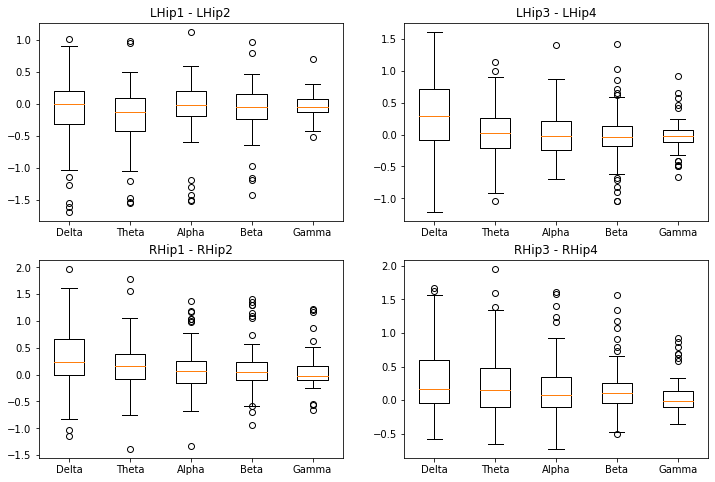

In [44]:
hip_chans = ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']
fig, axs = plt.subplots(2,2)
for idx, chan in enumerate(hip_chans):
    chan_filtered = power_log_chg[power_log_chg['Channel'] == chan]
    axs[idx // 2, idx % 2].boxplot(chan_filtered.loc[:,'Delta_log_chg':'Gamma_log_chg'])
    axs[idx // 2, idx % 2].set_xticklabels(freqs)
    axs[idx // 2, idx % 2].set_title(chan)

fig.set_size_inches(12, 8)

All is not lost! While it seems that LHip1 - LHip2 does center at zero for all frequency bands, the other channels have ~75% of responses showing increased delta power.

These results are interesting. I wonder if there are any other channels we could check?

In [45]:
power_log_chg.groupby('Channel')['ID'].count()

Channel
LHip1 - LHip2    78
LHip3 - LHip4    78
LPIH4 - LPIH1    10
LPIH4 - LPIH3    10
LPS1 - LPS2      10
LPS3 - LPS4      10
LatT1 - LatT2    12
LatT3 - LatT4    12
MIns1 - MIns2    12
MIns3 - MIns4    12
PIns1 - PIns2    12
PIns3 - PIns4    12
RHip1 - RHip2    78
RHip1 - RHip3    12
RHip3 - RHip4    66
RST1 - RST2      12
RST3 - RST4      12
Name: ID, dtype: int64

As you can see, all of the other channels only have 12 entries, which is to say that they were only recorded for one patient. We can't draw any conclusions about stimulation in a given brain region based on data from one patient, so we'll look at that data when we get to the patient-by-patient analysis. For now, let's confirm the channel-level effect by plotting PSDs and evoked potentials.

100:


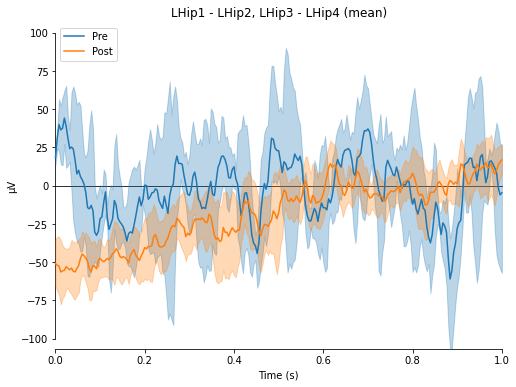

103 skipped
105:


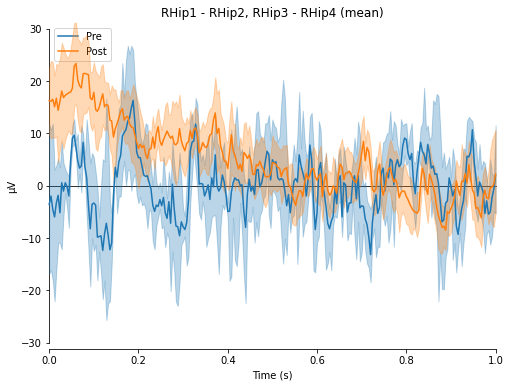

106 skipped
109:


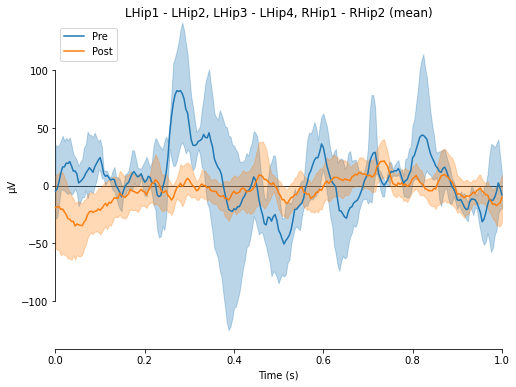

110:


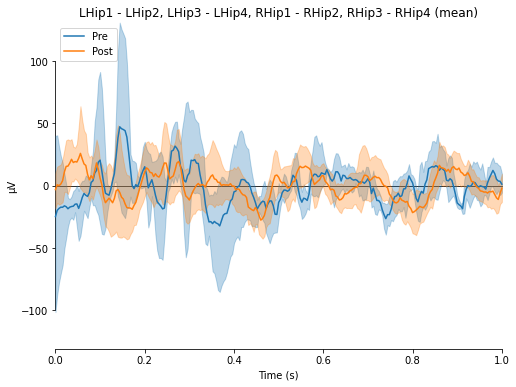

111:


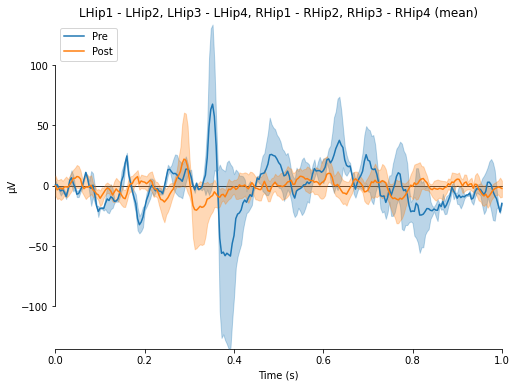

112:


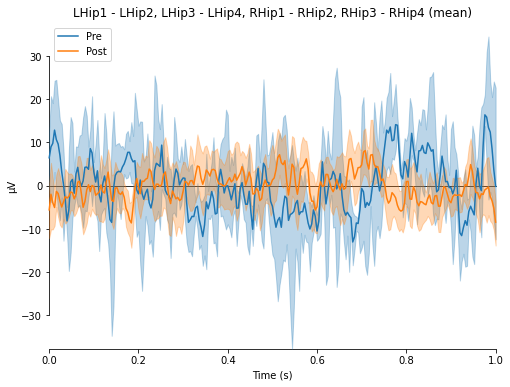

113:


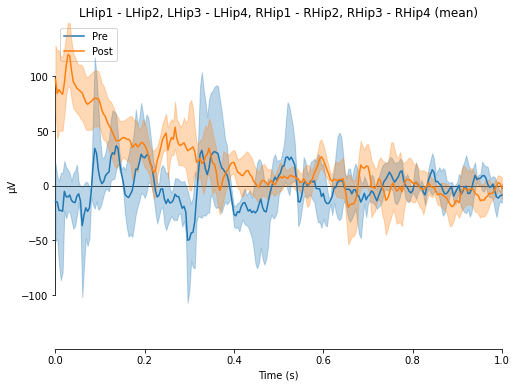

c:\Users\seand\eeg_proj\ecog\my_ecog_utils.py:11: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw.set_annotations(saved_ann)


115:


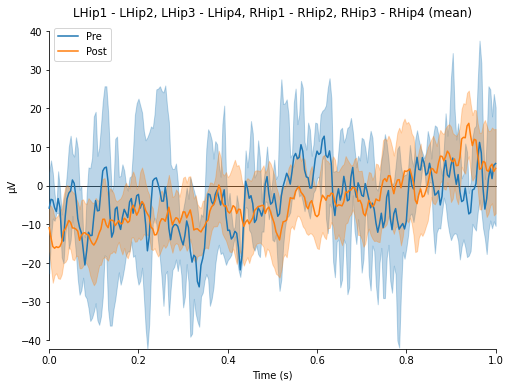

In [46]:
mne.set_log_level('WARNING')
for pt_num in pts_w_any_stim:
    raw = read_with_annotations(pt_num)
    evts, event_id = mne.events_from_annotations(raw, {'BAD_': 0, 'post_shock': 2, 'pre_shock': 1})
    epochs = mne.Epochs(raw, evts, event_id=event_id, tmin=0, tmax=1, baseline=(0.5,1.0))

    if pt_num == 100:
        epochs.rename_channels({'Hip1 - Hip2': 'LHip1 - LHip2', 'Hip3 - Hip4': 'LHip3 - LHip4'})
    elif pt_num == 113:
        epochs.rename_channels(lambda s: s.replace('H', 'Hip'))

    # drop segments that overlap with shocks
    # i.e. those that are shorter than 1 second. May change tmax in the future
    epochs.drop_bad()

    # pre_evoked = epochs['pre_shock'].average()
    # post_evoked = epochs['post_shock'].average()
    # mne.viz.plot_compare_evokeds({'Pre': pre_evoked, 'Post': post_evoked})

    pre_evoked = list(epochs['pre_shock'].iter_evoked())
    post_evoked = list(epochs['post_shock'].iter_evoked())
    hip_chans_subset = list(filter(lambda c: c in epochs.info['ch_names'], hip_chans))
    if len(hip_chans_subset) == 0:
        print(f'{pt_num} skipped')
        continue
    print(f'{pt_num}:')
    mne.viz.plot_compare_evokeds({'Pre': pre_evoked, 'Post': post_evoked}, combine='mean', picks=hip_chans_subset)

I figured out how to get evoked potentials first, so that's where we'll start. To make the analysis simpler, I've limited the initial graphs to the patients who have hippocampal electrodes for now, but later on, we can look at the other patients' evoked potentials as well. These graphs show what happens before stimulation in blue and after stimulation in orange. The pre-shock periods shouldn't actually have much correlation, so I'm using it as a control to represent the absense of a pattern. The orange post-shock evoked potential is what I'm actually focusing on. The translucent areas represent confidence intervals across stimulations.

The first thing I see is that a lot of patients still have post-stim drift, even after applying our automatic labeling algorithm. 100 drifts upward, 105 drifts down, and 113 drifts down. Opening up the raw voltage traces, it seems like each of these drifts is limited to a single channel and therefore, we'd probably be better off throwing out the one channel with a particularly long drift than we would if we delayed the post-stim period even longer and risked losing data. That said, I am interested to debug the algorithm and find out why it decided that the dy/dx changed sign before it really did. I assume the moving average did not cover a large enough time frame, and that the sign might have changed locally before it did globally. I think that I could fix this by extending the period for the moving average of the voltage without changing it for the derivative, although I would also need to adjust the back-count appropriately.

Anyway, for now, let's look at what happens to each channel, and possibly a confidence interval across patients, if we can get one.

In [47]:
mne.set_log_level('WARNING')
post_evoked_list = [[], [], [], []]
epochs_master = []
for pt_num in pts_w_any_stim:
    raw = read_with_annotations(pt_num)
    evts, event_id = mne.events_from_annotations(raw, {'BAD_': 0, 'post_shock': 2, 'pre_shock': 1})
    epochs = mne.Epochs(raw, evts, event_id=event_id, tmin=0, tmax=1, baseline=(0.5,1.0))

    if pt_num == 100:
        epochs.rename_channels({'Hip1 - Hip2': 'LHip1 - LHip2', 'Hip3 - Hip4': 'LHip3 - LHip4'})
    elif pt_num == 113:
        epochs.rename_channels(lambda s: s.replace('H', 'Hip'))

    # drop segments that overlap with shocks
    # i.e. those that are shorter than 1 second. May change tmax in the future
    epochs.drop_bad()

    # pre_evoked = epochs['pre_shock'].average()
    for i in range(4):
        if hip_chans[i] in epochs.info['ch_names']:
            post_evoked_list[i].append(epochs['post_shock'].average(picks=hip_chans[i]))
    # mne.viz.plot_compare_evokeds({'Pre': pre_evoked, 'Post': post_evoked})

c:\Users\seand\eeg_proj\ecog\my_ecog_utils.py:11: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw.set_annotations(saved_ann)


C:\Users\seand\AppData\Local\Temp/ipykernel_8444/2407734594.py:8: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(evokeds)


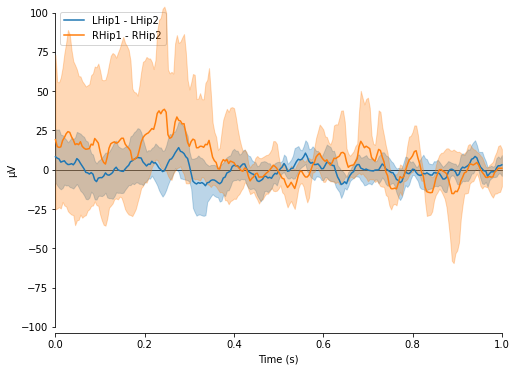

C:\Users\seand\AppData\Local\Temp/ipykernel_8444/2407734594.py:13: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(evokeds)


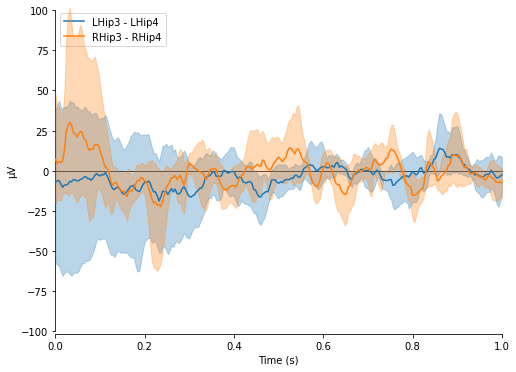

[<Figure size 576x432 with 1 Axes>]

In [48]:
for list_for_ch in post_evoked_list:
    for evoked in list_for_ch:
        evoked.rename_channels(lambda x: 'XHip')
evokeds = {
    hip_chans[0]: post_evoked_list[0],
    hip_chans[2]: post_evoked_list[2]
}
mne.viz.plot_compare_evokeds(evokeds)
evokeds = {
    hip_chans[1]: post_evoked_list[1],
    hip_chans[3]: post_evoked_list[3]
}
mne.viz.plot_compare_evokeds(evokeds)

- stat permutation analyses to determine which frequency bands == bootstrapping
- shuffle from 12 baselines
- convert log to dB

Well, there are certainly differences between the channels in their evoked potentials. I have no idea how to interpret them though, so I'll leave that to John.

I remember John also asked for a composite evoked potential averaged across all patients. This will take a bit of data wrangling, so I'll need to ask if he wants me to split up the data by channel or lump all of the channels together.

In [4]:
mne.set_log_level('WARNING')
post_evoked_list = [[], [], [], []]
epochs_master = []
pts_w_any_stim = [100, 103, 105, 106, 109, 110, 111, 112, 113, 115]
freqs = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
hip_chans = ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']
for pt_num in pts_w_any_stim:
    raw = read_with_annotations(pt_num)
    evts, event_id = mne.events_from_annotations(raw, {'BAD_': 0, 'post_shock': 2, 'pre_shock': 1})
    epochs = mne.Epochs(raw, evts, event_id=event_id, tmin=0, tmax=1, baseline=(0.5,1.0))

    if pt_num == 100:
        epochs.rename_channels({'Hip1 - Hip2': 'LHip1 - LHip2', 'Hip3 - Hip4': 'LHip3 - LHip4'})
    elif pt_num == 113:
        epochs.rename_channels(lambda s: s.replace('H', 'Hip'))

    # drop segments that overlap with shocks
    # i.e. those that are shorter than 1 second. May change tmax in the future
    epochs.drop_bad()
    epochs.load_data()

    non_hip_chs = list(filter(lambda c: c not in hip_chans, epochs.info['ch_names']))
    if len(non_hip_chs) == 4:
        continue

    epochs.drop_channels(non_hip_chs)
    print(pt_num)
    print(epochs.info['ch_names'])
    epochs_master.append(epochs)
    # mne.viz.plot_compare_evokeds({'Pre': pre_evoked, 'Post': post_evoked})

100
['LHip1 - LHip2', 'LHip3 - LHip4']
105
['RHip1 - RHip2', 'RHip3 - RHip4']
109
['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2']
110
['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']
111
['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']
112
['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']
113
['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']
115
['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']


c:\Users\seand\eeg_proj\ecog\my_ecog_utils.py:13: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw.set_annotations(saved_ann)


phase locking value calc

In [2]:
mne.set_log_level('WARNING')
post_evoked_list = [[], [], [], []]
post_epochs_master = []
pts_w_any_stim = [100, 103, 105, 106, 109, 110, 111, 112, 113, 115]
pts_w_any_stim = [103, 106, 110, 111, 112, 113, 115]
freqs = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
hip_chans = ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']
for pt_num in pts_w_any_stim:
    raw = read_with_annotations(pt_num)
    evts, event_id = mne.events_from_annotations(raw, {'BAD_': 0, 'post_shock': 2})
    epochs = mne.Epochs(raw, evts, event_id=event_id, tmin=0, tmax=1, baseline=(0.5,1.0))

    if pt_num == 100:
        epochs.rename_channels({'Hip1 - Hip2': 'LHip1 - LHip2', 'Hip3 - Hip4': 'LHip3 - LHip4'})
    elif pt_num == 113:
        epochs.rename_channels(lambda s: s.replace('H', 'Hip'))

    # drop segments that overlap with shocks
    # i.e. those that are shorter than 1 second. May change tmax in the future
    epochs.drop_bad()
    epochs.load_data()

    non_hip_chs = list(filter(lambda c: c not in hip_chans, epochs.info['ch_names']))
    if len(non_hip_chs) == 4:
        continue

    epochs.drop_channels(non_hip_chs)
    print(pt_num)
    print(epochs.info['ch_names'])
    post_epochs_master.append(epochs)
    # mne.viz.plot_compare_evokeds({'Pre': pre_evoked, 'Post': post_evoked})

110
['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']
111
['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']
112
['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']
113
['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']
115
['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']


c:\Users\seand\eeg_proj\ecog\my_ecog_utils.py:13: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw.set_annotations(saved_ann)


In [3]:
post_epochs = mne.concatenate_epochs(post_epochs_master)

In [29]:
from mne_connectivity import spectral_connectivity_epochs
plv = spectral_connectivity_epochs(post_epochs, method='plv', fmin=8, fmax=13, faverage=True)

<AxesSubplot:>

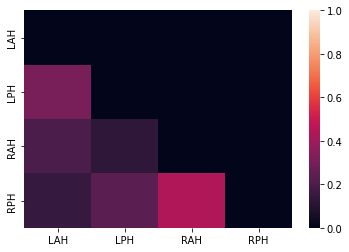

In [40]:
import seaborn as sns
labels = ['LAH', 'LPH', 'RAH', 'RPH']
sns.heatmap(plv.get_data(output='dense').reshape(4, 4), xticklabels=labels, yticklabels=labels, vmin=0, vmax=1)

<AxesSubplot:>

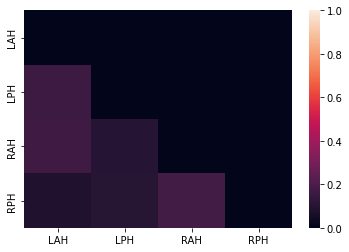

In [47]:
plv = spectral_connectivity_epochs(post_epochs, method='plv', fmin=40, fmax=57, faverage=True)
sns.heatmap(plv.get_data(output='dense').reshape(4, 4), xticklabels=labels, yticklabels=labels, vmin=0, vmax=1)

<AxesSubplot:>

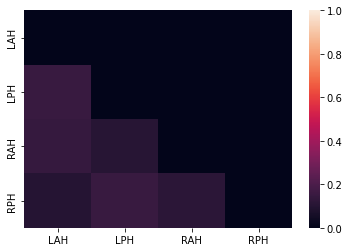

In [48]:
plv = spectral_connectivity_epochs(post_epochs, method='plv', fmin=67, fmax=80, faverage=True)
sns.heatmap(plv.get_data(output='dense').reshape(4, 4), xticklabels=labels, yticklabels=labels, vmin=0, vmax=1)

C:\Users\seand\AppData\Local\Temp/ipykernel_28400/4208066334.py:1: RuntimeWarning: fmin=4.000 Hz corresponds to 4.016 < 5 cycles based on the epoch length 1.004 sec, need at least 1.250 sec epochs or fmin=4.980. Spectrum estimate will be unreliable.
  plv = spectral_connectivity_epochs(post_epochs, method='plv', fmin=4, fmax=7, faverage=True)


<AxesSubplot:>

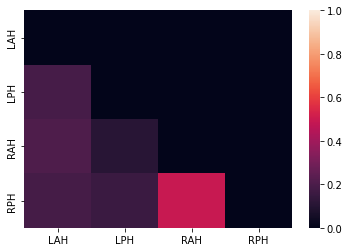

In [52]:
plv = spectral_connectivity_epochs(post_epochs, method='plv', fmin=4, fmax=7, faverage=True)
sns.heatmap(plv.get_data(output='dense').reshape(4, 4), xticklabels=labels, yticklabels=labels, vmin=0, vmax=1)

cross-frequency calc

In [6]:
from pactools import raw_to_mask, Comodulogram
import math
from typing import Literal

def calc_comod(pt_num, pre_post: Literal['pre', 'post'], chan=3, ax=None):
    raw = read_with_annotations(pt_num)
    raw.load_data()
    raw.notch_filter(62.5)
    evts, _ = mne.events_from_annotations(raw, {pre_post+'_shock': 2})
    tmin = 0
    tmax = 1
    # ixs determines what channel to look at
    low_sig, high_sig, mask = raw_to_mask(raw, ixs=chan, events=evts, tmin=tmin, tmax=tmax)
    lo_th = 4
    hi_th = 8
    estimator = Comodulogram(
        fs=raw.info['sfreq'],
        low_fq_range=np.linspace(lo_th,hi_th,24), low_fq_width=2.0,
        high_fq_range=np.linspace(hi_th, 100, 40),
        method='tort', progress_bar=True, # tort is better for short signals, says Hulsemann 2019
        n_surrogates=20, n_jobs=2)
    estimator.fit(low_sig, high_sig, mask)
    estimator.plot(tight_layout=False, contour_method='comod_max', contour_level=0.10, axs=ax)
    get_fq_index = lambda fq: math.floor((fq-(hi_th+1))/((125-(hi_th+1))/estimator.comod_.shape[2]))
    print(estimator.get_maximum_pac())
    return estimator.comod_, estimator.surrogate_max_

In [99]:
get_fq_index = lambda fq: math.floor((fq-13)/((125-13)/80))

In [107]:
np.argmax(comod[0][1])

55

In [108]:
comod[0,1,55]

0.034943393305521354

In [111]:
get_fq_index(91)

55

In [120]:
0.3913*24

9.3912

Opening raw data file data/113/stimulated_ieeg.fif...
Isotrak not found
    Range : 0 ... 55943 =      0.000 ...   223.772 secs
Ready.
Reading 0 ... 55943  =      0.000 ...   223.772 secs...
Setting up band-stop filter from 62 - 63 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.84
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 61.59 Hz)
- Upper passband edge: 63.16 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.41 Hz)
- Filter length: 1651 samples (6.604 sec)

Used Annotations descriptions: ['post_shock']
[........................................] 100% | 61.68 sec | comodulogram: tort 
(array([3.39130435]), array([93.53164557]), array([0.03450824]))


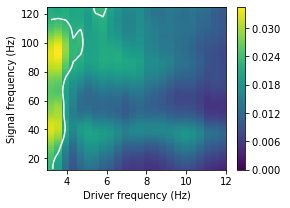

In [122]:
comod, surrog = calc_comod(113, 'post', chan=2)

(array([4., 2., 4., 0., 0., 2., 0., 2., 3., 3.]),
 array([0.01562358, 0.01747206, 0.01932055, 0.02116903, 0.02301752,
        0.024866  , 0.02671449, 0.02856297, 0.03041146, 0.03225994,
        0.03410843]),
 <BarContainer object of 10 artists>)

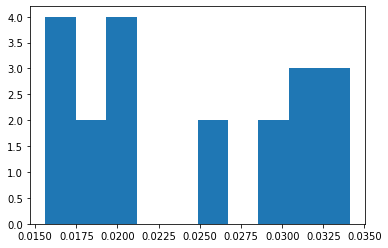

In [66]:
plt.hist(surrog[0])

In [53]:
np.percentile(surrog, 90)

0.03257823639862717

Opening raw data file data/105/stimulated_ieeg.fif...
Isotrak not found
    Range : 0 ... 56855 =      0.000 ...   227.420 secs
Ready.
Reading 0 ... 56855  =      0.000 ...   227.420 secs...
Setting up band-stop filter from 62 - 63 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.84
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 61.59 Hz)
- Upper passband edge: 63.16 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.41 Hz)
- Filter length: 1651 samples (6.604 sec)

Used Annotations descriptions: ['post_shock']
[........................................] 100% | 28.63 sec | comodulogram: tort 
(array([6.60869565]), array([36.30769231]), array([0.00218191]))
Opening raw data file data/110/stimulated_ieeg.fif...
Isotrak not found
    Range : 0 ... 429

c:\Users\seand\eeg_proj\venv\lib\site-packages\pactools\comodulogram.py:506: UserWarning: No contour levels were found within the data range.
  axs[i].contour(comod_[i].T, levels=levels, colors='w',


---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.84
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 61.59 Hz)
- Upper passband edge: 63.16 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.41 Hz)
- Filter length: 1651 samples (6.604 sec)

Used Annotations descriptions: ['post_shock']
[........................................] 100% | 26.18 sec | comodulogram: tort 
(array([6.26086957]), array([31.58974359]), array([0.00545554]))
Opening raw data file data/111/stimulated_ieeg.fif...
Isotrak not found
    Range : 0 ... 42191 =      0.000 ...   168.764 secs
Ready.
Reading 0 ... 42191  =      0.000 ...   168.764 secs...
Setting up band-stop filter from 62 - 63 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowe

c:\Users\seand\eeg_proj\ecog\my_ecog_utils.py:15: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw.set_annotations(saved_ann)


[........................................] 100% | 19.21 sec | comodulogram: tort 
(array([5.39130435]), array([66.97435897]), array([0.00218523]))
Opening raw data file data/105/stimulated_ieeg.fif...
Isotrak not found
    Range : 0 ... 56855 =      0.000 ...   227.420 secs
Ready.
Reading 0 ... 56855  =      0.000 ...   227.420 secs...
Setting up band-stop filter from 62 - 63 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.84
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 61.59 Hz)
- Upper passband edge: 63.16 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.41 Hz)
- Filter length: 1651 samples (6.604 sec)

Used Annotations descriptions: ['post_shock']
[........................................] 100% | 22.38 sec | comodulogram: tort 
(array([7.3

c:\Users\seand\eeg_proj\ecog\my_ecog_utils.py:15: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw.set_annotations(saved_ann)


Used Annotations descriptions: ['post_shock']
[........................................] 100% | 25.54 sec | comodulogram: tort 
(array([4.17391304]), array([38.66666667]), array([0.00253094]))
Opening raw data file data/105/stimulated_ieeg.fif...
Isotrak not found
    Range : 0 ... 56855 =      0.000 ...   227.420 secs
Ready.
Reading 0 ... 56855  =      0.000 ...   227.420 secs...
Setting up band-stop filter from 62 - 63 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.84
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 61.59 Hz)
- Upper passband edge: 63.16 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.41 Hz)
- Filter length: 1651 samples (6.604 sec)

Used Annotations descriptions: ['post_shock']
[........................................] 100%

c:\Users\seand\eeg_proj\ecog\my_ecog_utils.py:15: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw.set_annotations(saved_ann)


[........................................] 100% | 25.63 sec | comodulogram: tort 
(array([6.08695652]), array([69.33333333]), array([0.00151332]))
Opening raw data file data/105/stimulated_ieeg.fif...
Isotrak not found
    Range : 0 ... 56855 =      0.000 ...   227.420 secs
Ready.
Reading 0 ... 56855  =      0.000 ...   227.420 secs...
Setting up band-stop filter from 62 - 63 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.84
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 61.59 Hz)
- Upper passband edge: 63.16 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.41 Hz)
- Filter length: 1651 samples (6.604 sec)

Used Annotations descriptions: ['post_shock']
[........................................] 100% | 21.24 sec | comodulogram: tort 
(array([4.3

c:\Users\seand\eeg_proj\ecog\my_ecog_utils.py:15: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw.set_annotations(saved_ann)


[........................................] 100% | 21.09 sec | comodulogram: tort 
(array([5.39130435]), array([57.53846154]), array([0.00254942]))


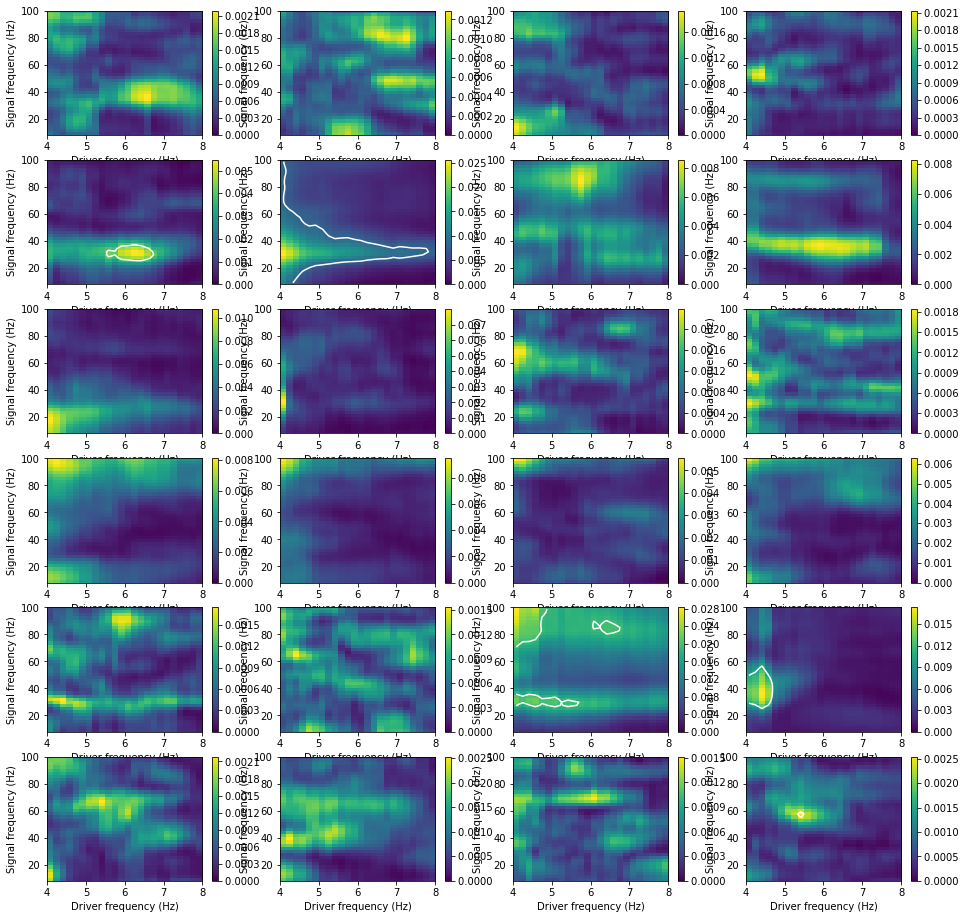

In [72]:
fig, axs = plt.subplots(6, 4)
fig.set_size_inches(16, 16)
comod_zscores_pre = {}
for chan in range(4):
    for i, pt_num in enumerate([105, 110, 111, 112, 113, 115]):
        comod_zscores_pre[pt_num] = calc_comod(pt_num, 'post', chan, [axs[i][chan]])

In [39]:
comod_zscores_pre[113][0].shape

(24, 80)

this one is using Z-scores

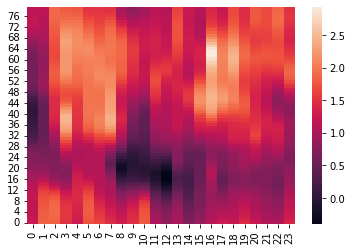

In [34]:
# this should have dimensions 24 x 80
comod_avg_pre = np.mean(np.array(list(comod_zscores_pre.values())), axis=0)[0]
import seaborn as sns
ax = sns.heatmap(comod_avg_pre.T)
ax.invert_yaxis()

this one is using raw values, and it matches what I see in the individual plots

In [31]:
np.array([x[0] for x in list(comod_zscores_pre.values())]).shape

(6, 1, 24, 40)

In [49]:
92/4

23.0

In [53]:
np.linspace(8, 100, 24)

array([  8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,  44.,  48.,
        52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,  88.,  92.,
        96., 100.])

Text(0.5, 1.0, 'Post-Stimulation Modulation Index')

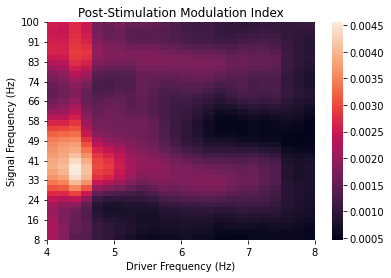

In [73]:
from matplotlib.ticker import FormatStrFormatter
# this should have dimensions 24 x 40
comod_avg_pre = np.mean(np.array([x[0] for x in list(comod_zscores_pre.values())]), axis=0)[0]
import seaborn as sns
ax = sns.heatmap(comod_avg_pre.T)
ax.invert_yaxis()
ax.set_xticks(np.linspace(0,24,5))
ax.set_xticklabels(np.linspace(4, 8, 5).astype(int), rotation=0)
ax.set_xlabel('Driver Frequency (Hz)')
ax.set_yticks(np.linspace(0, 40, 12))
ax.set_yticklabels(np.linspace(8, 100, 12).astype(int))
ax.set_ylabel('Signal Frequency (Hz)')
ax.set_title('Post-Stimulation Modulation Index')

using raw values, but taking median instead of mean to reduce influence of outlier patients?

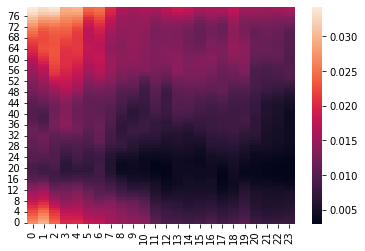

In [37]:
# this should have dimensions 24 x 80
comod_avg_pre = np.median(np.array(list(comod_zscores_pre.values())), axis=0)[0]
import seaborn as sns
ax = sns.heatmap(comod_avg_pre.T)
ax.invert_yaxis()

Opening raw data file data/110/stimulated_ieeg.fif...
Isotrak not found
    Range : 0 ... 42983 =      0.000 ...   171.932 secs
Ready.
Used Annotations descriptions: ['post_shock']
[........................................] 100% | 35.75 sec | comodulogram: tort 


c:\Users\seand\eeg_proj\venv\lib\site-packages\pactools\comodulogram.py:506: UserWarning: No contour levels were found within the data range.
  axs[i].contour(comod_[i].T, levels=levels, colors='w',


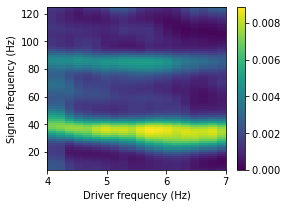

In [6]:
calc_comod(110, 'post')
None

Opening raw data file data/115/stimulated_ieeg.fif...
Isotrak not found
    Range : 0 ... 59951 =      0.000 ...   239.804 secs
Ready.
Used Annotations descriptions: ['post_shock']
[                                        ] 0% | 0.00 sec | comodulogram: tort 

c:\Users\seand\eeg_proj\ecog\my_ecog_utils.py:13: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw.set_annotations(saved_ann)


[........................................] 100% | 34.75 sec | comodulogram: tort 


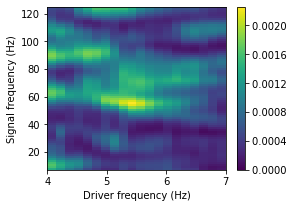

In [7]:
calc_comod(115, 'post')
None

correlation between max comodulogram z index and correlation between memory and gamma
correlation between max comodulogram z index and memory

In [77]:
comod_diffs = []
for pt_num in [100,111,112,113,115]:
    comod_diffs.append(calc_comod(pt_num, 'post') - calc_comod(pt_num, 'pre'))

[........................................] 100% | 20.70 sec | comodulogram: tort 
[........................................] 100% | 11.38 sec | comodulogram: tort 
[........................................] 100% | 12.75 sec | comodulogram: tort 
[........................................] 100% | 10.73 sec | comodulogram: tort 
[........................................] 100% | 15.17 sec | comodulogram: tort 
[........................................] 100% | 15.54 sec | comodulogram: tort 
[........................................] 100% | 17.53 sec | comodulogram: tort 
[........................................] 100% | 13.05 sec | comodulogram: tort 
[                                        ] 0% | 0.00 sec | comodulogram: tort 

c:\Users\seand\eeg_proj\ecog\my_ecog_utils.py:13: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw.set_annotations(saved_ann)


[........................................] 100% | 25.60 sec | comodulogram: tort 
[                                        ] 0% | 0.00 sec | comodulogram: tort 

c:\Users\seand\eeg_proj\ecog\my_ecog_utils.py:13: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw.set_annotations(saved_ann)


[........................................] 100% | 15.44 sec | comodulogram: tort 


In [78]:
comod_diffs = np.array(comod_diffs)
comod_diffs.shape

(5, 20, 11)

In [79]:
comod_diffs[:,2,0]

array([-1.88567943,  0.193467  ,  0.55773845,  4.49786475, -2.13127447])

In [74]:
%matplotlib inline

<AxesSubplot:>

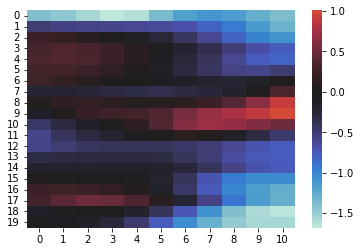

In [80]:
import seaborn as sns
sns.heatmap(np.average(comod_diffs, axis=0), center=0)

what i have to do is look at the PAC matrix before and after stimulation and test if there is a difference. If that doesn't work, and it probably won't, then the other option is to just measure PAC before stimulation, see if there is any, and then try to correlate it with memory

## Stats

The basic idea of this is analysis is to create a bootstrapped dataset, calaculate summary statistics on the bootstrapped dataset, and then use this to get P-values for whether or not there is a statistically significant difference between the pre-shock periods and the post-shock periods. We create our bootstrapped dataset by comparing each stimulation to a randomly selected baseline from the same patient. This baseline could be from a different channel or a different trial, or both. These random selections are performed with replacement because I see no reason not to. I elected to use medians as my summary statistic rather than means because we know our data has some positive-skewed outliers.

John said something about performing a t-test on the results. t-test compares means between 2 samples. However, my current method does not provide me with 2 samples, since I subtract the baseline power from the stim power before calculating the median difference. The first problem is that I am using medians instead of means, but I guess I can change that fairly easily. The second problem is that I don't have 2 different datasets to compare, only the one. This aligns with the matched-pair study design, since we are matching each stimulation to a baseline. I suppose this doesn't necessarily have to be true, so we could try putting together 2 separate datasets for the baselines and for the stims. They would have different sample sizes, though, but IIRC the 2-sample t-test can handle that with pooled variance. How would we bootstrap in that case, though? Doesn't the 2-sample t-test already account for the potential variation in the sample mean/median? I watched a video on it, and apparently the 2-sample t-test requires large sample sizes because the t-distribution is only met when the central limit theorem applies. In contrast, bootstrapping works with smaller datasets. I think we can try both approaches and compare the results.

In [50]:
summary_stats = pd.DataFrame(columns=freqs)
for trial in range(100):
    bootstrapped_diffs = pd.DataFrame(columns=stims.columns)
    for pt_num in pts_w_any_stim:
        stims_for_pt = stims[stims['ID'] == pt_num]
        baselines_for_pt = baselines[baselines['ID'] == pt_num]
        random_baselines = baselines_for_pt.sample(n=len(stims_for_pt), replace=True).loc[:,'Delta':'Gamma']
        random_baselines = random_baselines.reset_index().drop('index', axis=1)
        shuffled_stims = stims_for_pt.reset_index().drop('index', axis=1)
        # drops the channel, ID, and trial so that we can take the log10
        stim_power_only = shuffled_stims.loc[:,'Delta':'Gamma']
        # get the difference between the powers in decibels
        diffs = 10 * (np.log10(stim_power_only) - np.log10(random_baselines))
        diffs['Channel'] = shuffled_stims['Channel']
        diffs['ID'] = shuffled_stims['ID']
        diffs['Trial'] = shuffled_stims['Trial']
        bootstrapped_diffs = bootstrapped_diffs.append(diffs)

    bootstrapped_diffs = bootstrapped_diffs.drop('Stim', axis=1)
    summary_stats = summary_stats.append(bootstrapped_diffs.median(numeric_only=True).to_frame().transpose())

As a side note, I was able to cut execution time by 90% (17s to 1.7s, for 10 trials) by using Pandas's built-in sample instead of building my own. Nice! I compare the 2 methods below to check that they give similar results, which they do

In [51]:
# Slow Method of Random Sampling
# random_baselines = pd.DataFrame(columns=freqs)
# for i in range(len(stims_for_pt)):
#     idx_to_use = random.randrange(len(baselines_for_pt))
#     random_baselines = random_baselines.append(baselines_for_pt.loc[idx_to_use, 'Delta':'Gamma'])

# Fast Method of Random Sampling
stims_for_pt = stims[stims['ID'] == 112]
baselines_for_pt = baselines[baselines['ID'] == 112].reset_index()
random_baselines = baselines_for_pt.sample(n=len(stims_for_pt), replace=True).loc[:,'Delta':'Gamma']

random_baselines.reset_index().drop('index', axis=1)

Delta         Theta         Alpha          Beta         Gamma
0   1.098794e-08  7.507022e-09  5.289069e-09  2.696116e-09  4.448349e-10
1   8.373332e-09  5.877860e-09  2.291110e-09  1.070176e-09  2.972141e-10
2   1.430905e-08  4.923091e-09  2.106618e-09  1.200030e-09  1.395171e-10
3   8.373332e-09  5.877860e-09  2.291110e-09  1.070176e-09  2.972141e-10
4   1.098794e-08  7.507022e-09  5.289069e-09  2.696116e-09  4.448349e-10
5   5.794071e-09  5.167029e-09  1.639848e-09  4.741066e-10  8.853743e-11
6   1.230933e-08  8.894198e-09  3.881099e-09  1.205693e-09  2.665269e-10
7   1.430905e-08  4.923091e-09  2.106618e-09  1.200030e-09  1.395171e-10
8   1.230933e-08  8.894198e-09  3.881099e-09  1.205693e-09  2.665269e-10
9   1.230933e-08  8.894198e-09  3.881099e-09  1.205693e-09  2.665269e-10
10  4.533961e-09  4.065879e-09  1.911975e-09  7.610402e-10  1.520972e-10
11  4.533961e-09  4.065879e-09  1.911975e-09  7.610402e-10  1.520972e-10
12  8.373332e-09  5.877860e-09  2.291110e-09  1.070176e-09  2.972141e-10
13  1.153442e-08  7.976091e-09  4.109772e-09  2.813639e-09  4.477111e-10
14  1.098794e-08  7.507022e-09  5.289069e-09  2.696116e-09  4.448349e-10
15  8.569277e-09  3.612064e-09  1.789804e-09  9.420179e-10  1.113586e-10
16  1.153442e-08  7.976091e-09  4.109772e-09  2.813639e-09  4.477111e-10
17  1.230933e-08  8.894198e-09  3.881099e-09  1.205693e-09  2.665269e-10
18  8.569277e-09  3.612064e-09  1.789804e-09  9.420179e-10  1.113586e-10
19  1.153442e-08  7.976091e-09  4.109772e-09  2.813639e-09  4.477111e-10
20  2.458599e-08  7.309654e-09  1.298903e-09  9.726519e-10  2.371240e-10
21  4.829046e-09  6.264523e-09  7.168874e-09  2.365717e-09  1.227979e-10
22  8.373332e-09  5.877860e-09  2.291110e-09  1.070176e-09  2.972141e-10
23  1.230933e-08  8.894198e-09  3.881099e-09  1.205693e-09  2.665269e-10
24  1.153442e-08  7.976091e-09  4.109772e-09  2.813639e-09  4.477111e-10
25  4.533961e-09  4.065879e-09  1.911975e-09  7.610402e-10  1.520972e-10
26  1.098794e-08  7.507022e-09  5.289069e-09  2.696116e-09  4.448349e-10
27  1.230933e-08  8.894198e-09  3.881099e-09  1.205693e-09  2.665269e-10
28  8.373332e-09  5.877860e-09  2.291110e-09  1.070176e-09  2.972141e-10
29  1.230933e-08  8.894198e-09  3.881099e-09  1.205693e-09  2.665269e-10
30  1.098794e-08  7.507022e-09  5.289069e-09  2.696116e-09  4.448349e-10
31  4.533961e-09  4.065879e-09  1.911975e-09  7.610402e-10  1.520972e-10
32  2.458599e-08  7.309654e-09  1.298903e-09  9.726519e-10  2.371240e-10
33  8.569277e-09  3.612064e-09  1.789804e-09  9.420179e-10  1.113586e-10
34  1.098794e-08  7.507022e-09  5.289069e-09  2.696116e-09  4.448349e-10
35  4.377453e-09  4.092747e-09  1.884286e-09  7.648528e-10  1.045861e-10
36  1.098794e-08  7.507022e-09  5.289069e-09  2.696116e-09  4.448349e-10
37  1.098794e-08  7.507022e-09  5.289069e-09  2.696116e-09  4.448349e-10
38  4.533961e-09  4.065879e-09  1.911975e-09  7.610402e-10  1.520972e-10
39  4.377453e-09  4.092747e-09  1.884286e-09  7.648528e-10  1.045861e-10
40  8.569277e-09  3.612064e-09  1.789804e-09  9.420179e-10  1.113586e-10
41  2.458599e-08  7.309654e-09  1.298903e-09  9.726519e-10  2.371240e-10
42  4.533961e-09  4.065879e-09  1.911975e-09  7.610402e-10  1.520972e-10
43  6.870642e-09  6.324977e-09  3.293312e-09  2.885279e-09  5.854494e-10

For the heck of it, let's take a look at the distribution of the summary statistics for each bootstrapped sample.

<AxesSubplot:title={'center':'Distribution of Medians'}>

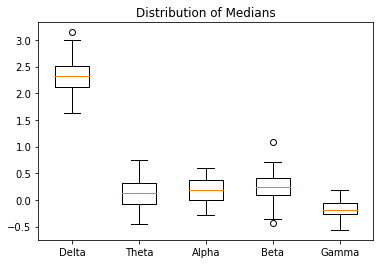

In [52]:
fig, ax = plt.subplots()
ax.boxplot(summary_stats)
ax.set_xticklabels(summary_stats.columns)
ax.set_title('Distribution of Medians')
ax

Here is my first attempt at the permutation test. Here, we permute the baselines across channels and trials, but we always subtract pre from post.

In [53]:
reference_stats = pd.DataFrame(columns=freqs)
for trial in range(50):
    permuted_diffs = pd.DataFrame(columns=freqs)
    for pt_num in pts_w_any_stim:
        stims_for_pt = stims[stims['ID'] == pt_num]
        baselines_for_pt = baselines[baselines['ID'] == pt_num]

        repeated_baselines = pd.DataFrame(np.repeat(baselines_for_pt.values, 4, axis=0), columns=baselines_for_pt.columns)
        random_baselines = repeated_baselines.sample(frac=1).loc[:,freqs]
        random_baselines = random_baselines.reset_index().drop('index', axis=1)
        random_baselines = random_baselines.astype(float)
        shuffled_stims = stims_for_pt.reset_index().drop('index', axis=1)
        # drops the channel, ID, and trial so that we can take the log10
        stim_power_only = shuffled_stims.loc[:,freqs]

        # get the difference between the powers in decibels
        diffs = 10 * (np.log10(stim_power_only) - np.log10(random_baselines))
        diffs['Channel'] = shuffled_stims['Channel']
        diffs['ID'] = shuffled_stims['ID']
        diffs['Trial'] = shuffled_stims['Trial']
        diffs = diffs.dropna()
        permuted_diffs = permuted_diffs.append(diffs)
        
    # since we took the difference before taking the means, we don't have anything left to subtract
    # use pooled variance
    num_stims = len(stims)
    num_baselines = len(baselines)
    stdev_stims = (10 * np.log10(stims.loc[:,freqs])).std()
    stdev_baselines = (10 * np.log10(baselines.loc[:,freqs])).std()
    pooled_var = np.sqrt(np.power(stdev_stims, 2) / num_stims + np.power(stdev_baselines, 2) / num_baselines)
    simple_var = permuted_diffs.loc[:,freqs].std() / math.sqrt(len(permuted_diffs))
    t = permuted_diffs.loc[:,freqs].mean() / pooled_var
    reference_stats = reference_stats.append(t.to_frame().transpose())

    # bootstrapped_diffs = bootstrapped_diffs.drop('Stim', axis=1)
    # summary_stats = summary_stats.append(bootstrapped_diffs.median(numeric_only=True).to_frame().transpose())

    # t = ttest_ind('''TODO'''[:,freqs], 0)
    # reference_stats.append(t.statistic)

Little graph

NameError: name 't_rearrange' is not defined

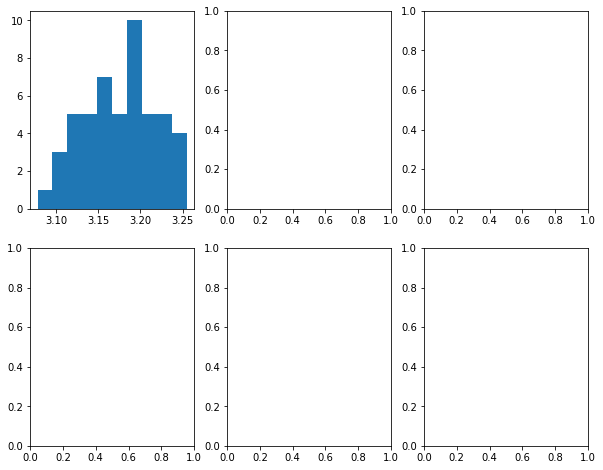

In [54]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(10, 8)
t_distro = pd.DataFrame(data=np.array(reference_stats), columns=freqs)
for i in range(5):
    ax[i//3, i%3].hist(t_distro[freqs[i]])
    ax[i//3, i%3].axvline(t_rearrange[freqs[i]], color='orange')
    ax[i//3, i%3].set_title(freqs[i])

In [ ]:
from scipy.stats import ttest_rel, ttest_1samp

ttest_results = ttest_1samp(power_log_chg.loc[:,'Delta_log_chg':'Gamma_log_chg'], 0)
print(ttest_results)
t_stats = ttest_results[0]

Ttest_1sampResult(statistic=array([8.63203257, 1.05126812, 1.22587629, 1.76801657, 0.89120271]), pvalue=array([1.06807755e-16, 2.93703452e-01, 2.20890673e-01, 7.77402244e-02,
       3.73299879e-01]))


In [ ]:
for i, freq in enumerate(freqs):
    t_delta = t_stats[i]
    p_val = len(t_distro[t_distro[freq] > t_delta]) / len(t_distro)
    print(f'{freq}: {p_val}')

Delta: 0.0
Theta: 0.0
Alpha: 0.0
Beta: 0.0
Gamma: 0.0


In [ ]:
mne.stats.permutation_t_test(
    power_log_chg.loc[:,'Delta_log_chg':'Gamma_log_chg'].to_numpy(),
    n_permutations=100
)
# delta theta alpha beta gamma

(array([8.63203257, 1.05126812, 1.22587629, 1.76801657, 0.89120271]),
 array([0.01, 0.63, 0.52, 0.22, 0.76]),
 array([0.44715315, 0.45928347, 0.50450287, 0.5135482 , 0.53274595,
        0.54080181, 0.54836256, 0.58655943, 0.62009487, 0.62839745,
        0.64395375, 0.65440107, 0.671039  , 0.6813414 , 0.68173447,
        0.70804699, 0.7606212 , 0.76171979, 0.78849548, 0.80087575,
        0.8231405 , 0.85997903, 0.8737683 , 0.87868526, 0.90542287,
        0.91727794, 0.93296197, 0.96016584, 0.96904932, 0.97882566,
        0.98443565, 0.99024567, 0.99581133, 0.99999123, 1.00971338,
        1.02293287, 1.04282467, 1.06713813, 1.06874865, 1.07167276,
        1.11291065, 1.13938108, 1.14017691, 1.14436654, 1.15654331,
        1.17703394, 1.17801582, 1.19399024, 1.23269402, 1.23368531,
        1.28348144, 1.28642986, 1.30387697, 1.30597188, 1.31283239,
        1.32207697, 1.328129  , 1.34356291, 1.35188069, 1.35752658,
        1.3656414 , 1.41181955, 1.42019876, 1.42386656, 1.42469787,
      

In [ ]:
from scipy.stats import ttest_ind
reference_stats2 = pd.DataFrame(columns=freqs)
for trial in range(5):
    permuted_diffs = pd.DataFrame(columns=freqs)
    for pt_num in pts_w_any_stim:
        def rename_ch(ch):
            return ch.split('_')[0]
        stims_for_pt = power_log_chg.loc[power_log_chg['ID'] == pt_num,'Delta_post':'Gamma_post'].rename(rename_ch, axis=1)
        own_baselines = power_log_chg.loc[power_log_chg['ID'] == pt_num,'Delta_pre':'Gamma_pre'].rename(rename_ch, axis=1)

        # get the difference between the powers in decibels
        diffs = 10 * (np.log10(stims_for_pt) - np.log10(own_baselines))
        # diffs['Channel'] = shuffled_stims['Channel']
        # diffs['ID'] = shuffled_stims['ID']
        # diffs['Trial'] = shuffled_stims['Trial']
        permuted_diffs = permuted_diffs.append(diffs)
        
    # since we took the difference before taking the means, we don't have anything left to subtract
    # use pooled variance
    num_stims = len(stims)
    num_baselines = len(baselines)
    stdev_stims = (10 * np.log10(stims.loc[:,freqs])).std()
    stdev_baselines = (10 * np.log10(baselines.loc[:,freqs])).std()
    pooled_var = np.sqrt(np.power(stdev_stims, 2) / num_stims + np.power(stdev_baselines, 2) / num_baselines)

    simple_var = permuted_diffs.std() / math.sqrt(len(power_log_chg))
    t = permuted_diffs.mean() / pooled_var # simple_var
    reference_stats2 = reference_stats2.append(t.to_frame().transpose())
        

    # bootstrapped_diffs = bootstrapped_diffs.drop('Stim', axis=1)
    # summary_stats = summary_stats.append(bootstrapped_diffs.median(numeric_only=True).to_frame().transpose())

    # t = ttest_ind('''TODO'''[:,freqs], 0)
    # reference_stats.append(t.statistic)

In [ ]:
t_rearrange = reference_stats2.iloc[0]

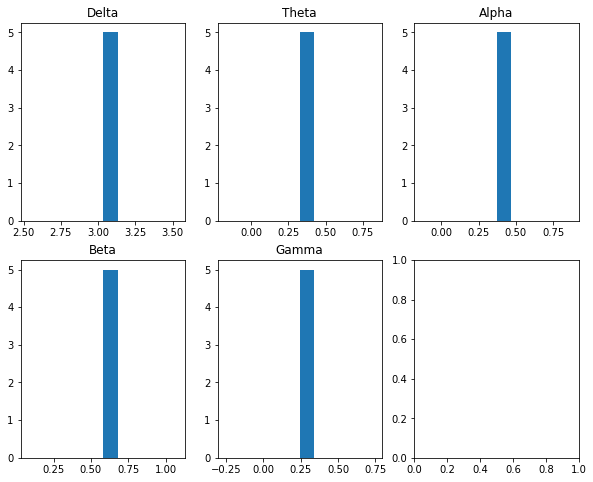

In [ ]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(10, 8)
t_distro = pd.DataFrame(data=np.array(reference_stats2), columns=freqs)
for i in range(5):
    ax[i//3, i%3].hist(t_distro[freqs[i]])
    # ax.set_xticklabels(summary_stats.columns)
    ax[i//3, i%3].set_title(freqs[i])

In [ ]:
from scipy.stats import ttest_ind
reference_stats3 = pd.DataFrame(columns=freqs)
for trial in range(100):
    # get the difference between the powers in decibels
    diffs = 10 * power_log_chg.loc[:,'Delta_log_chg':'Gamma_log_chg']
    signs = np.random.choice([-1.0, 1.0], diffs.shape)
    diffs *= signs

    diffs['Channel'] = shuffled_stims['Channel']
    diffs['ID'] = shuffled_stims['ID']
    diffs['Trial'] = shuffled_stims['Trial']
    diffs = diffs.dropna()
    diffs = diffs.rename(lambda f: f[:-len('_log_chg')] if f.endswith('_log_chg') else f, axis=1)
    
    # since we took the difference before taking the means, we don't have anything left to subtract
    # use pooled variance
    num_stims = len(stims)
    num_baselines = len(baselines)
    stdev_stims = (10 * np.log10(stims.loc[:,freqs])).std()
    stdev_baselines = (10 * np.log10(baselines.loc[:,freqs])).std()
    pooled_var = np.sqrt(np.power(stdev_stims, 2) / num_stims + np.power(stdev_baselines, 2) / num_baselines)
    simple_var = diffs.loc[:,freqs].std() / math.sqrt(len(diffs))
    t = diffs.loc[:,freqs].mean() / pooled_var
    reference_stats3 = reference_stats3.append(t.to_frame().transpose())
        

    # bootstrapped_diffs = bootstrapped_diffs.drop('Stim', axis=1)
    # summary_stats = summary_stats.append(bootstrapped_diffs.median(numeric_only=True).to_frame().transpose())

    # t = ttest_ind('''TODO'''[:,freqs], 0)
    # reference_stats.append(t.statistic)

In [ ]:
reference_stats3.head()

Delta     Theta     Alpha      Beta     Gamma
0  1.169334 -0.573587  0.942436  0.234107 -0.188205
0 -0.764728  0.247254 -0.186257  0.263974  0.300442
0 -0.689359 -0.086998 -0.216710 -1.113194 -0.329179
0 -1.296307 -0.831481 -0.086297 -0.208578  0.201559
0 -1.895540  0.037825 -0.517988 -0.230568  0.047573

NameError: name 't_og' is not defined

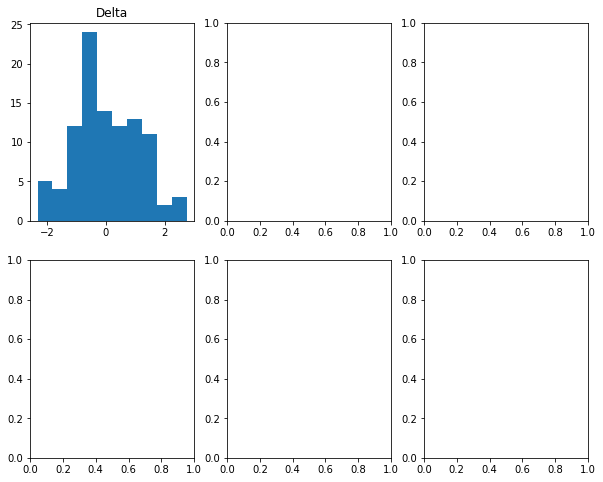

In [ ]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(10, 8)
t_distro = pd.DataFrame(data=np.array(reference_stats3), columns=freqs)
for i in range(5):
    ax[i//3, i%3].hist(t_distro[freqs[i]])
    # ax.set_xticklabels(summary_stats.columns)
    ax[i//3, i%3].set_title(freqs[i])
    ax[i//3, i%3].axvline(t_og[freqs[i]], color='orange')
    print(t_distro[freqs[i]])

In [ ]:
# get original t values
diffs = 10 * power_log_chg.loc[:,'Delta_log_chg':'Gamma_log_chg']
# signs = np.random.choice([-1.0, 1.0], diffs.shape)
# diffs *= signs

diffs['Channel'] = shuffled_stims['Channel']
diffs['ID'] = shuffled_stims['ID']
diffs['Trial'] = shuffled_stims['Trial']
diffs = diffs.dropna()
diffs = diffs.rename(lambda f: f[:-len('_log_chg')] if f.endswith('_log_chg') else f, axis=1)

# since we took the difference before taking the means, we don't have anything left to subtract
# use pooled variance
num_stims = len(stims)
num_baselines = len(baselines)
stdev_stims = (10 * np.log10(stims.loc[:,freqs])).std()
stdev_baselines = (10 * np.log10(baselines.loc[:,freqs])).std()
pooled_var = np.sqrt(np.power(stdev_stims, 2) / num_stims + np.power(stdev_baselines, 2) / num_baselines)
simple_var = diffs.loc[:,freqs].std() / math.sqrt(len(diffs))
t_og = diffs.loc[:,freqs].mean() / pooled_var

t_og

In [ ]:
illustration = power_log_chg[['ID', 'Trial', 'Channel', 'Delta_pre', 'Delta_post']]

|Original|Shuffled|EEGLAB|
|--|--|--|
|![](og_comparisons.png)|![](shuffled_comparisons.png)|![](eeglab_comparisons.png)|

# Stats per Channel

In [ ]:
temp = pd.DataFrame()
for ch in hip_chans:
    means = power_log_chg.loc[power_log_chg['Channel'] == ch, 'Delta_log_chg':'Gamma_log_chg'].mean()
    means = means.rename(lambda x: x[:-len('_log_chg')])
    means.name = ch
    temp = temp.append(means)
temp

Delta     Theta     Alpha      Beta     Gamma
LHip1 - LHip2 -0.115518 -0.186278 -0.070137 -0.072850 -0.040082
LHip3 - LHip4  0.264993  0.030503  0.010339 -0.037477 -0.014498
RHip1 - RHip2  0.312038  0.171456  0.118656  0.111954  0.071640
RHip3 - RHip4  0.294788  0.259953  0.186748  0.164837  0.070542

In [ ]:
p_vals = pd.DataFrame(columns=freqs)
p_vals['Channel'] = []
p_vals = p_vals.set_index('Channel')
for ch in hip_chans:
    results = mne.stats.permutation_t_test(
        power_log_chg.loc[power_log_chg['Channel'] == ch,'Delta_log_chg':'Gamma_log_chg'].to_numpy(),
        n_permutations=1000
    )[1]
    p_vals.loc[ch] = results

p_vals

Delta  Theta  Alpha   Beta  Gamma
Channel                                         
LHip1 - LHip2  0.133  0.006  0.409  0.262  0.177
LHip3 - LHip4  0.003  0.942  0.999  0.857  0.961
RHip1 - RHip2  0.001  0.010  0.103  0.130  0.196
RHip3 - RHip4  0.001  0.001  0.004  0.003  0.134

Because we just performed 20 t-tests, we'll apply FDR correction to ensure that we haven't accidentally P-hacked ourselves into significant results. I'm using the Benjamini-Hochberg method I found implemented on [Stack Overflow](https://stackoverflow.com/questions/7450957/how-to-implement-rs-p-adjust-in-python/33532498#33532498)

In [ ]:
def fdr_bh(p_vals):
    p = np.asarray(p_vals.values.flatten())
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    q[by_orig]
    p_adj = pd.DataFrame(q[by_orig].reshape((4, 5)), columns=p_vals.columns)
    p_adj['Channel'] = p_vals.index
    return p_adj.set_index('Channel')

In [ ]:
p_adj = fdr_bh(p_vals)
p_adj[p_adj < 0.05]

Delta     Theta     Alpha   Beta  Gamma
Channel                                                  
LHip1 - LHip2       NaN  0.017143       NaN    NaN    NaN
LHip3 - LHip4  0.012000       NaN       NaN    NaN    NaN
RHip1 - RHip2  0.006667  0.025000       NaN    NaN    NaN
RHip3 - RHip4  0.006667  0.006667  0.013333  0.012    NaN

['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']

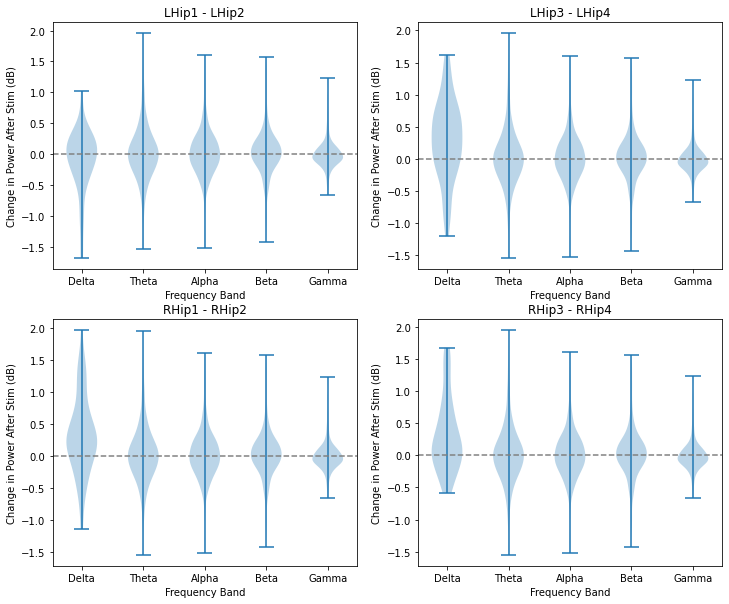

In [ ]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(12, 10)
for i, chan in enumerate(hip_chans):
    ax = axs[i // 2, i % 2]
    power_for_chan = power_log_chg[power_log_chg['Channel'] == chan]
    ax.violinplot([power_for_chan['Delta_log_chg'], power_log_chg['Theta_log_chg'], power_log_chg['Alpha_log_chg'], power_log_chg['Beta_log_chg'], power_log_chg['Gamma_log_chg']])
    ax.set_xticks(range(1,6), freqs)
    ax.set_xlabel('Frequency Band')
    ax.set_ylabel('Change in Power After Stim (dB)')
    ax.axhline(0, linestyle='--', c='gray')
    ax.set_title(chan)

# Memory Correlations

I'm going to try doing these in Excel first, since Pivot Tables generally make it easy to check a bunch of correlations. For that, I'll have to export the data to Excel.

In [ ]:
power_log_chg.to_csv('power_log_chg.csv')

Get memory data

In [55]:
memory_trials = pd.read_csv('memory_trials.csv').iloc[:,1:]
memory_trials = memory_trials.drop(11, axis=0)
memory_trials['ID'] = memory_trials['ID'].astype(int)
memory_trials

ID  Trial_1_Stim  Trial_2_Stim  Trial_3_Stim  Trial_1_Sham  Trial_2_Sham  \
0   100             4             6             6             7             7   
1   101             3             5             6             5             6   
2   102             7            10            11             4             8   
3   103             7             8            10             7             6   
4   104             4             4             6             5             6   
5   105             5             7             7             7             6   
6   106             8            10            12             9            10   
7   107             7            10            10             0             0   
8   108             2             5             7             4             7   
9   109             4             7             9             5             7   
10  110             5             5             7             7             7   
12  112             8             9            10             5             9   
13  113             7             9             9             6             8   
14  115             4             6             5             4             4   
15  200             4             3             5             2             2   
16  201             6             6             7             7             6   
17  202             4             5             7             4             5   
18  205             5             5             6             0             0   
19  206             4             7             7             6             5   
20  207             6             9             9             0             0   
21  208             5             8            11             0             0   
22  209             5             6             8             0             0   

    Trial_3_Sham   Avg_Sham  
0              9   7.666667  
1              9   6.666667  
2              8   6.666667  
3              7   6.666667  
4              5   5.333333  
5              7   6.666667  
6             12  10.333333  
7              0   0.000000  
8              6   5.666667  
9              9   6.666667  
10             8   7.333333  
12             8   7.333333  
13             8   7.333333  
14             7   5.000000  
15             4   2.666667  
16             8   7.000000  
17             7   5.333333  
18             0   0.000000  
19             5   5.333333  
20             0   0.000000  
21             0   0.000000  
22             0   0.000000

In [56]:
memory_trials = memory_trials.set_index(['ID', 'Avg_Sham']).stack().to_frame()
memory_trials['Trial'] = memory_trials.index.get_level_values(2)
memory_trials['Trial'] = memory_trials['Trial'].str[len('Trial_')].astype(int)
memory_trials = memory_trials.reset_index(level=2)
memory_trials = memory_trials[~memory_trials['level_2'].str.endswith('Sham')]
memory_trials = memory_trials.drop('level_2', axis=1)
memory_trials = memory_trials.rename(columns={0: 'Memory_Score'})
memory_trials = memory_trials.reset_index(level=1)
memory_trials

Avg_Sham  Memory_Score  Trial
ID                                
100  7.666667             4      1
100  7.666667             6      2
100  7.666667             6      3
101  6.666667             3      1
101  6.666667             5      2
..        ...           ...    ...
208  0.000000             8      2
208  0.000000            11      3
209  0.000000             5      1
209  0.000000             6      2
209  0.000000             8      3

[66 rows x 3 columns]

In [57]:
power_and_mem = power_log_chg.merge(memory_trials, on=['ID', 'Trial'], how='left')

In [58]:
power_and_mem = power_and_mem.dropna()

NOTE: the delay data is currently excluding pt 111 because his trials were dropped in the above cell. Technically, the delay data could use 111, but he is an extreme outlier, so I'll leave it alone for now.

In [59]:
memory_delayed = pd.read_csv('memory_delayed.csv').iloc[:,1:]
memory_delayed = memory_delayed.rename({'Memory_Stim': 'Delay_Mem_Stim', 'Memory_Sham': 'Delay_Mem_Sham'}, axis=1)
power_and_mem = power_and_mem.merge(memory_delayed, on='ID', how='left')

temp

In [60]:
power_and_mem

ID Trial        Channel    Delta_post    Theta_post    Alpha_post  \
0    100     1  LHip1 - LHip2  1.142425e-07  7.161263e-08  2.537439e-08   
1    100     1  LHip1 - LHip2  5.835947e-08  3.228662e-08  2.086371e-08   
2    100     1  LHip1 - LHip2  5.101078e-08  3.540437e-08  3.576591e-08   
3    100     1  LHip1 - LHip2  8.638911e-08  8.010154e-08  4.598185e-08   
4    100     1  LHip3 - LHip4  3.784396e-07  7.526684e-08  5.945997e-09   
..   ...   ...            ...           ...           ...           ...   
411  115     3  RHip1 - RHip2  9.711323e-08  5.704873e-08  2.026480e-08   
412  115     3  RHip3 - RHip4  1.015564e-07  2.902442e-08  3.397387e-09   
413  115     3  RHip3 - RHip4  3.798705e-08  1.329936e-08  2.844349e-09   
414  115     3  RHip3 - RHip4  9.366525e-08  3.898334e-08  1.177374e-08   
415  115     3  RHip3 - RHip4  9.523928e-08  4.836225e-08  8.531949e-09   

        Beta_post    Gamma_post  Stim_Num     Delta_pre  ...     Gamma_pre  \
0    1.169223e-08  6.854174e-10         1  7.676245e-08  ...  8.706455e-10   
1    8.328850e-09  7.199653e-10         2  7.676245e-08  ...  8.706455e-10   
2    1.402683e-08  6.067107e-10         3  7.676245e-08  ...  8.706455e-10   
3    9.420390e-09  5.334231e-10         4  7.676245e-08  ...  8.706455e-10   
4    3.396220e-09  4.870411e-10         1  7.599882e-08  ...  4.294396e-10   
..            ...           ...       ...           ...  ...           ...   
411  1.892534e-09  1.022950e-10         4  6.394327e-08  ...  1.573105e-10   
412  1.678384e-09  1.538645e-10         1  5.952048e-08  ...  2.623488e-10   
413  1.064764e-09  1.290604e-10         2  5.952048e-08  ...  2.623488e-10   
414  1.676138e-09  2.128235e-10         3  5.952048e-08  ...  2.623488e-10   
415  1.652413e-09  1.153763e-10         4  5.952048e-08  ...  2.623488e-10   

     Delta_log_chg  Theta_log_chg  Alpha_log_chg  Beta_log_chg  Gamma_log_chg  \
0         0.172679      -0.046258      -0.186435     -0.062647      -0.103886   
1        -0.119037      -0.392225      -0.271439     -0.209959      -0.082530   
2        -0.177487      -0.352190      -0.037361      0.016416      -0.156860   
3         0.051310       0.002394       0.071756     -0.156475      -0.212770   
4         0.697190       0.141332      -0.126444     -0.027167       0.054663   
..             ...            ...            ...           ...            ...   
411       0.181484       0.656745       0.410674      0.016787      -0.186903   
412       0.232041       0.275843      -0.144449     -0.043531      -0.231741   
413      -0.195031      -0.063090      -0.221611     -0.241169      -0.308086   
414       0.196912       0.403959       0.395321     -0.044113      -0.090860   
415       0.204150       0.497586       0.255454     -0.050304      -0.356763   

     Avg_Sham  Memory_Score  Delay_Mem_Stim  Delay_Mem_Sham  
0    7.666667           4.0             4.0               5  
1    7.666667           4.0             4.0               5  
2    7.666667           4.0             4.0               5  
3    7.666667           4.0             4.0               5  
4    7.666667           4.0             4.0               5  
..        ...           ...             ...             ...  
411  5.000000           5.0             4.0               5  
412  5.000000           5.0             4.0               5  
413  5.000000           5.0             4.0               5  
414  5.000000           5.0             4.0               5  
415  5.000000           5.0             4.0               5  

[416 rows x 23 columns]

In [61]:
power_and_mem.groupby(['ID', 'Trial', 'Channel'])['Delta_post'].apply(lambda x: np.mean(np.log10(x)))

ID   Trial  Channel      
100  1      LHip1 - LHip2   -7.132985
            LHip3 - LHip4   -6.622917
            LatT1 - LatT2   -8.948115
            LatT3 - LatT4   -7.150520
     2      LHip1 - LHip2   -7.111502
                               ...   
115  2      RHip3 - RHip4   -7.391316
     3      LHip1 - LHip2   -7.160820
            LHip3 - LHip4   -7.819107
            RHip1 - RHip2   -7.051179
            RHip3 - RHip4   -7.115816
Name: Delta_post, Length: 108, dtype: float64

In [62]:
power_and_mem.columns

Index(['ID', 'Trial', 'Channel', 'Delta_post', 'Theta_post', 'Alpha_post',
       'Beta_post', 'Gamma_post', 'Stim_Num', 'Delta_pre', 'Theta_pre',
       'Alpha_pre', 'Beta_pre', 'Gamma_pre', 'Delta_log_chg', 'Theta_log_chg',
       'Alpha_log_chg', 'Beta_log_chg', 'Gamma_log_chg', 'Avg_Sham',
       'Memory_Score', 'Delay_Mem_Stim', 'Delay_Mem_Sham'],
      dtype='object')

## Pipeline

In [63]:
from sklearn.linear_model import LinearRegression

f1 = power_and_mem[power_and_mem['Channel'] == 'LHip3 - LHip4'][['ID', 'Trial', 'Delta_log_chg', 'Memory_Score', 'Avg_Sham']].groupby(by=['ID', 'Trial']).mean()
f2 = power_and_mem[power_and_mem['Channel'] == 'RHip1 - RHip2'][['ID', 'Trial', 'Beta_log_chg', 'Memory_Score', 'Avg_Sham']].groupby(by=['ID', 'Trial']).mean()
f3 = power_and_mem[power_and_mem['Channel'] == 'RHip3 - RHip4'][['ID', 'Trial', 'Gamma_log_chg', 'Memory_Score', 'Avg_Sham']].groupby(by=['ID', 'Trial']).mean()

features = f1.merge(f2).merge(f3)
model = LinearRegression()
X = features[['Delta_log_chg', 'Beta_log_chg', 'Gamma_log_chg']]
Y = features['Memory_Score'] - features['Avg_Sham']
model.fit(X, Y)
model.score(X, Y)

0.4944114468043147

## Trial Memory Raw vs Power Post

Okay, so check this out. I've found the first power-memory correlation that withstands FDR. It's the post-stim delta and theta frequency bands in the LHip3 - LHip4 channel. It's actually stronger if you use the regular t-test instead of the permutation test, and it's a lot stronger if you look at the change from sham to stim instead of looking at just stim memory

In [64]:
# import importlib
# import stats_pipeline
# importlib.reload(stats_pipeline)
from stats_pipeline import do_stats

Good, the correlation remained after I applied the notch filter at 62.5 Hz and expanded the delta band down to 0.1 Hz

Averaging across stims in the same patient, channel, and trial


Channel Frequency         r         P
0   LHip1 - LHip2     Delta -0.197181  0.432890
1   LHip1 - LHip2     Theta -0.361490  0.140494
2   LHip1 - LHip2     Alpha -0.363539  0.138093
3   LHip1 - LHip2      Beta -0.267808  0.282633
4   LHip1 - LHip2     Gamma -0.212892  0.396344
5   LHip3 - LHip4     Delta -0.734884  0.000513
6   LHip3 - LHip4     Theta -0.693920  0.001401
7   LHip3 - LHip4     Alpha -0.533597  0.022571
8   LHip3 - LHip4      Beta -0.547359  0.018717
9   LHip3 - LHip4     Gamma -0.565415  0.014468
10  RHip1 - RHip2     Delta  0.163816  0.515997
11  RHip1 - RHip2     Theta  0.120166  0.634824
12  RHip1 - RHip2     Alpha  0.086607  0.732571
13  RHip1 - RHip2      Beta  0.161986  0.520762
14  RHip1 - RHip2     Gamma  0.242021  0.333254
15  RHip3 - RHip4     Delta  0.080073  0.776660
16  RHip3 - RHip4     Theta -0.020115  0.943276
17  RHip3 - RHip4     Alpha -0.135468  0.630247
18  RHip3 - RHip4      Beta -0.133832  0.634422
19  RHip3 - RHip4     Gamma  0.001735  0.995104

Linear regression:


Frequency         Delta    Theta  Alpha  Beta  Gamma
Channel                                             
LHip1 - LHip2       NaN      NaN    NaN   NaN    NaN
LHip3 - LHip4  0.010253  0.01401    NaN   NaN    NaN
RHip1 - RHip2       NaN      NaN    NaN   NaN    NaN
RHip3 - RHip4       NaN      NaN    NaN   NaN    NaN

Fisher Exact:


Frequency      Delta  Theta  Alpha  Beta  Gamma
Channel                                        
LHip1 - LHip2    NaN    NaN    NaN   NaN    NaN
LHip3 - LHip4    NaN    NaN    NaN   NaN    NaN
RHip1 - RHip2    NaN    NaN    NaN   NaN    NaN
RHip3 - RHip4    NaN    NaN    NaN   NaN    NaN

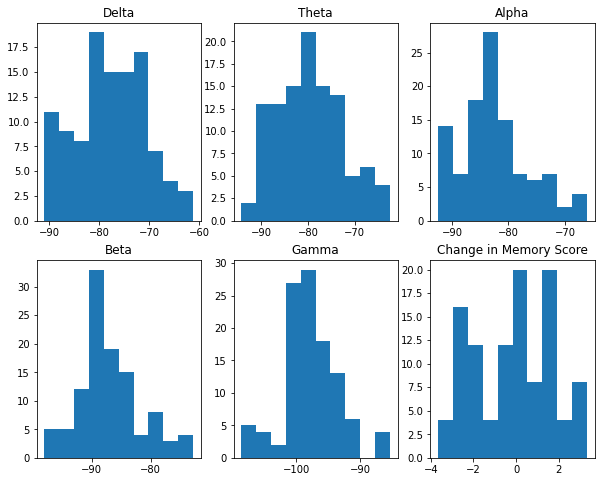

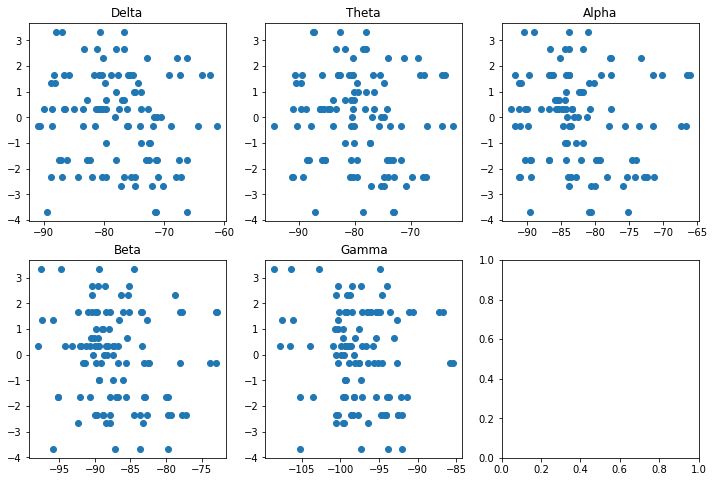

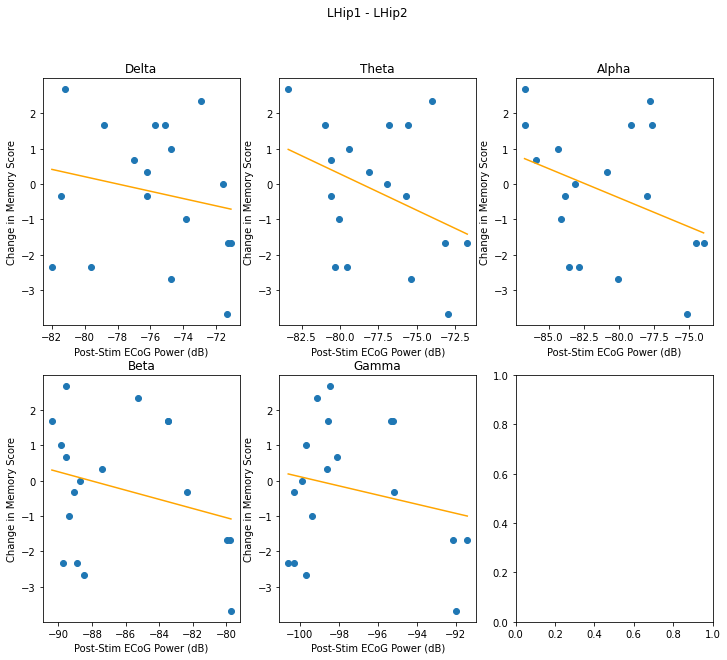

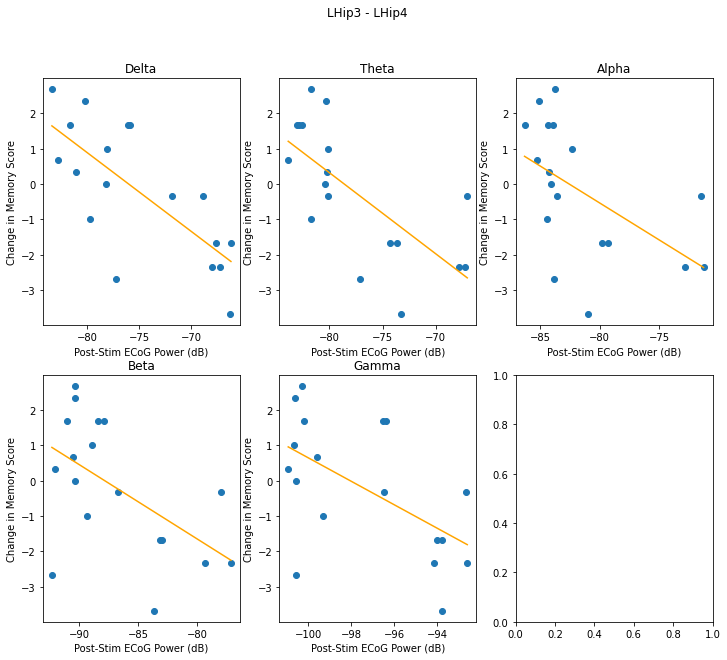

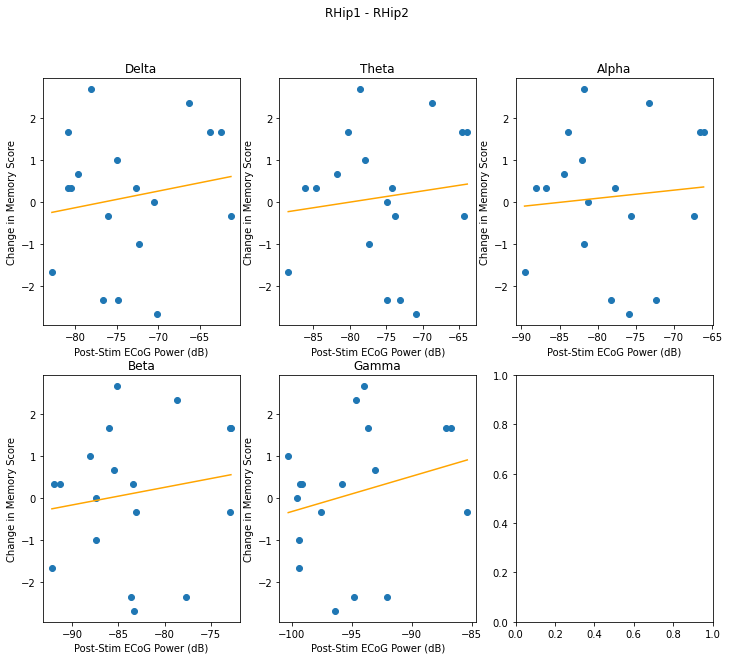

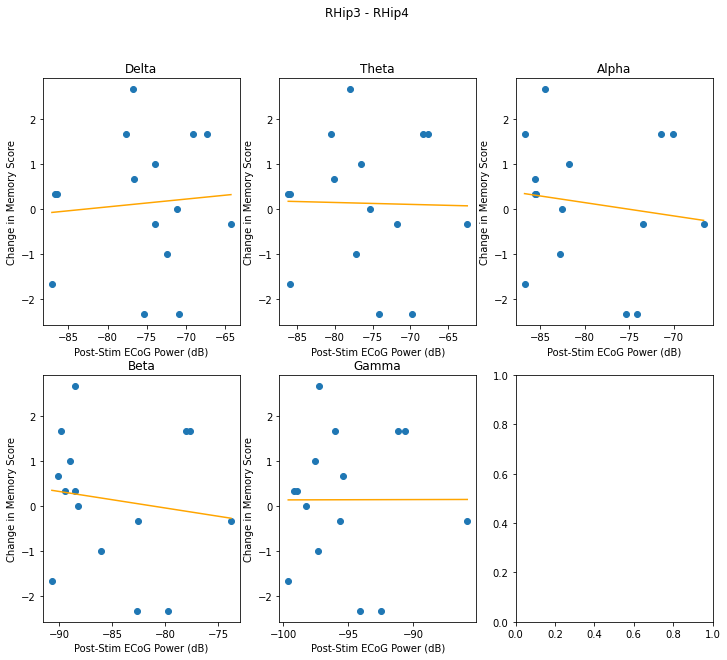

In [65]:
do_stats(power_and_mem, '10 * log($FREQ_post) / log(10)', 'Memory_Score - Avg_Sham', 'Post-Stim ECoG Power (dB)', 'Change in Memory Score')

In contrast, if you look at the stim memory without subtracting for sham, the correlation weakens to the point where FDR erases it

Averaging across stims in the same patient, channel, and trial


Channel Frequency         r         P
0   LHip1 - LHip2     Delta -0.310598  0.209675
1   LHip1 - LHip2     Theta -0.248375  0.320320
2   LHip1 - LHip2     Alpha -0.176318  0.484013
3   LHip1 - LHip2      Beta -0.036591  0.885387
4   LHip1 - LHip2     Gamma  0.034571  0.891676
5   LHip3 - LHip4     Delta -0.493652  0.037342
6   LHip3 - LHip4     Theta -0.508469  0.031186
7   LHip3 - LHip4     Alpha -0.369855  0.130872
8   LHip3 - LHip4      Beta -0.324763  0.188537
9   LHip3 - LHip4     Gamma -0.261031  0.295453
10  RHip1 - RHip2     Delta  0.144308  0.567798
11  RHip1 - RHip2     Theta  0.198140  0.430610
12  RHip1 - RHip2     Alpha  0.229676  0.359237
13  RHip1 - RHip2      Beta  0.347252  0.157983
14  RHip1 - RHip2     Gamma  0.502392  0.033608
15  RHip3 - RHip4     Delta  0.082495  0.770070
16  RHip3 - RHip4     Theta  0.106330  0.706054
17  RHip3 - RHip4     Alpha  0.072973  0.796060
18  RHip3 - RHip4      Beta  0.092404  0.743265
19  RHip3 - RHip4     Gamma  0.251932  0.365034

Linear regression:


Frequency      Delta  Theta  Alpha  Beta  Gamma
Channel                                        
LHip1 - LHip2    NaN    NaN    NaN   NaN    NaN
LHip3 - LHip4    NaN    NaN    NaN   NaN    NaN
RHip1 - RHip2    NaN    NaN    NaN   NaN    NaN
RHip3 - RHip4    NaN    NaN    NaN   NaN    NaN

Fisher Exact:


Frequency      Delta  Theta  Alpha  Beta  Gamma
Channel                                        
LHip1 - LHip2    NaN    NaN    NaN   NaN    NaN
LHip3 - LHip4    NaN    NaN    NaN   NaN    NaN
RHip1 - RHip2    NaN    NaN    NaN   NaN    NaN
RHip3 - RHip4    NaN    NaN    NaN   NaN    NaN

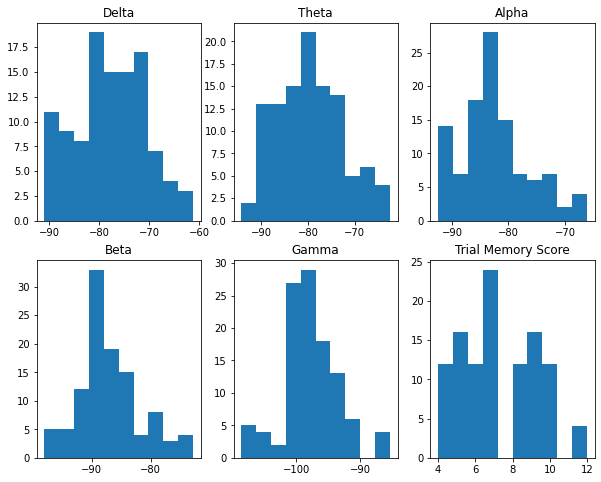

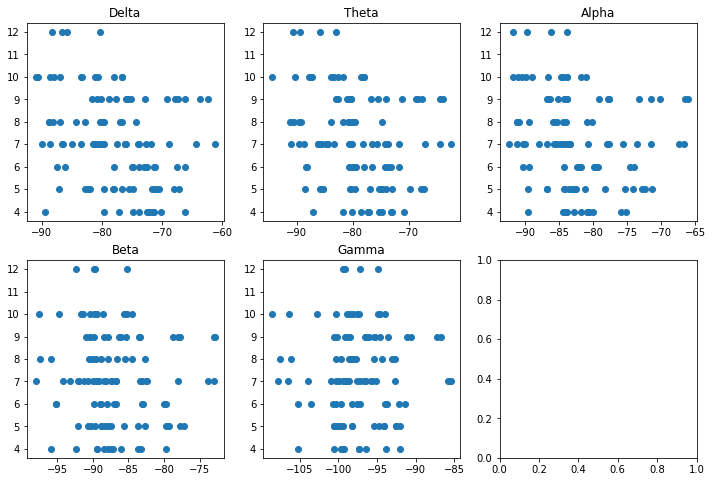

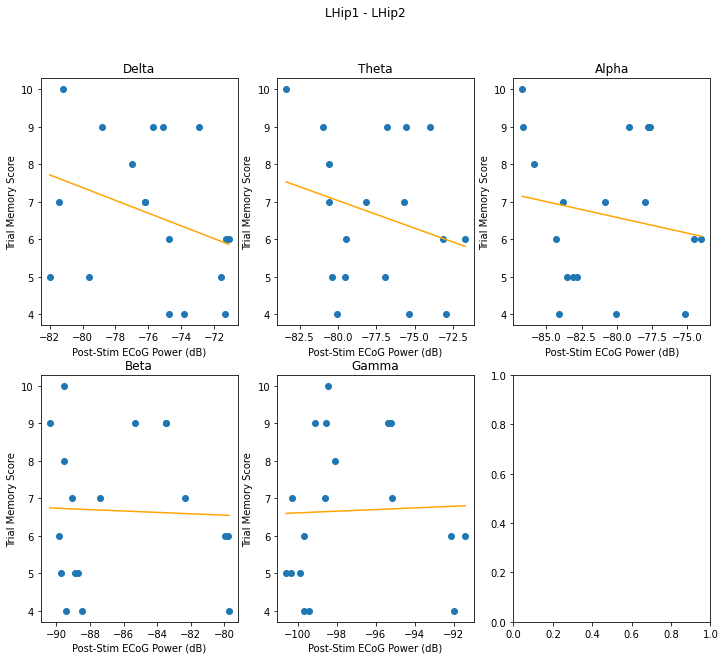

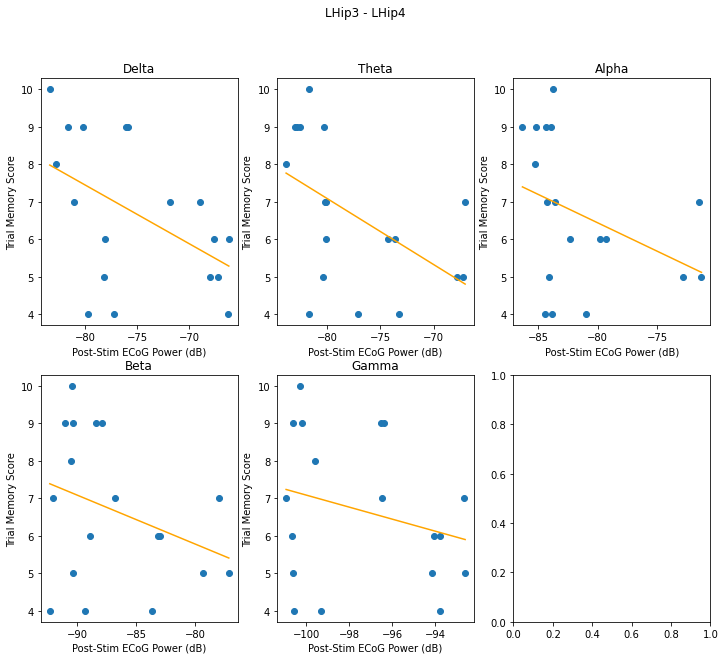

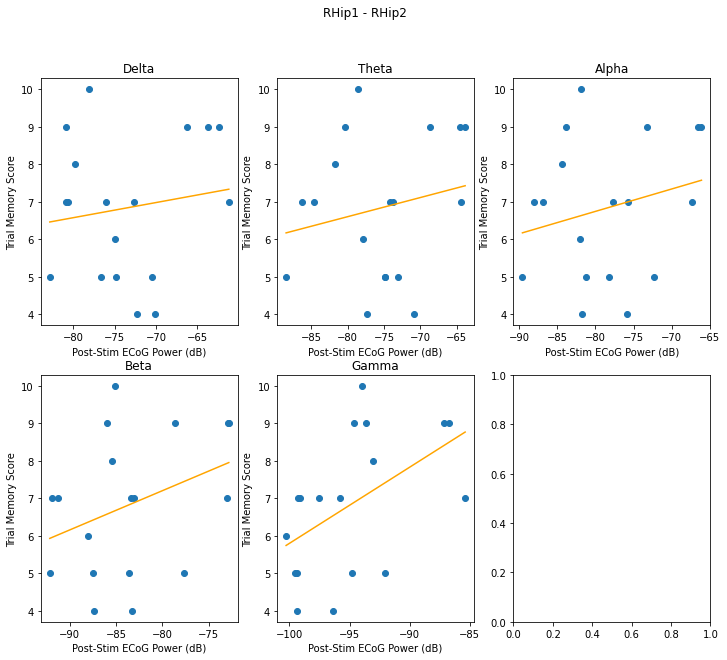

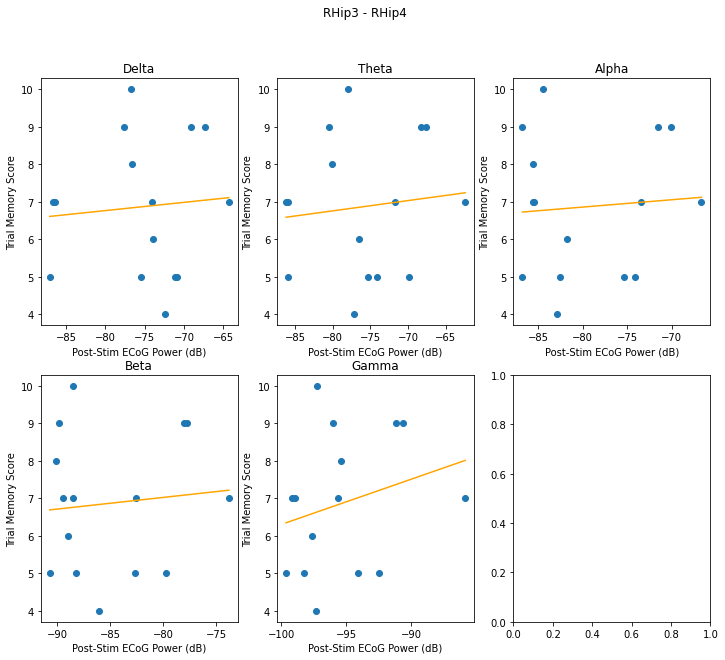

In [66]:
do_stats(power_and_mem, '10 * log($FREQ_post) / log(10)', 'Memory_Score', 'Post-Stim ECoG Power (dB)', 'Trial Memory Score')

In the next section, I want to see if this correlation holds up if we look at power *change* isntead of just post-stim power

## Trial Memory Chg vs Power Change (averaged)

The answer is no. The delta band in LHip3 - LHip4 does give us the linear regression and two-way table with the lowest P-value, but both of these are about 0.08, even before we apply FDR. Strange.

Averaging across stims in the same patient, channel, and trial
Fisher Exact P-value = 0.33484162895927627 for Theta band in LHip1 - LHip2


Power         
                Decrease Increase
Memory Decrease        7        2
       Increase        4        4

Fisher Exact P-value = 0.08235294117647061 for Delta band in LHip3 - LHip4


Power         
                Decrease Increase
Memory Decrease        0        9
       Increase        3        5

Fisher Exact P-value = 0.34693541752365364 for Beta band in LHip3 - LHip4


Power         
                Decrease Increase
Memory Decrease        3        6
       Increase        5        3

Fisher Exact P-value = 0.3499588646647469 for Gamma band in RHip1 - RHip2


Power         
                Decrease Increase
Memory Decrease        3        4
       Increase        7        3

Fisher Exact P-value = 0.2087912087912086 for Beta band in RHip3 - RHip4


Power         
                Decrease Increase
Memory Decrease        0        6
       Increase        3        5

Channel Frequency         r         P
0   LHip1 - LHip2     Delta -0.158189  0.530709
1   LHip1 - LHip2     Theta -0.061348  0.808919
2   LHip1 - LHip2     Alpha -0.249119  0.318825
3   LHip1 - LHip2      Beta -0.052225  0.836944
4   LHip1 - LHip2     Gamma  0.056907  0.822537
5   LHip3 - LHip4     Delta -0.404081  0.096292
6   LHip3 - LHip4     Theta -0.398277  0.101632
7   LHip3 - LHip4     Alpha -0.186982  0.457521
8   LHip3 - LHip4      Beta -0.207189  0.409412
9   LHip3 - LHip4     Gamma -0.083998  0.740361
10  RHip1 - RHip2     Delta  0.142065  0.573894
11  RHip1 - RHip2     Theta  0.159644  0.526887
12  RHip1 - RHip2     Alpha -0.075827  0.764907
13  RHip1 - RHip2      Beta -0.137228  0.587136
14  RHip1 - RHip2     Gamma -0.221239  0.377637
15  RHip3 - RHip4     Delta -0.057306  0.839249
16  RHip3 - RHip4     Theta -0.099766  0.723521
17  RHip3 - RHip4     Alpha -0.194105  0.488193
18  RHip3 - RHip4      Beta -0.393530  0.146713
19  RHip3 - RHip4     Gamma -0.418642  0.120403

Linear regression:


Frequency      Delta  Theta  Alpha  Beta  Gamma
Channel                                        
LHip1 - LHip2    NaN    NaN    NaN   NaN    NaN
LHip3 - LHip4    NaN    NaN    NaN   NaN    NaN
RHip1 - RHip2    NaN    NaN    NaN   NaN    NaN
RHip3 - RHip4    NaN    NaN    NaN   NaN    NaN

Fisher Exact:


Frequency      Delta  Theta  Alpha  Beta  Gamma
Channel                                        
LHip1 - LHip2    NaN    NaN    NaN   NaN    NaN
LHip3 - LHip4    NaN    NaN    NaN   NaN    NaN
RHip1 - RHip2    NaN    NaN    NaN   NaN    NaN
RHip3 - RHip4    NaN    NaN    NaN   NaN    NaN

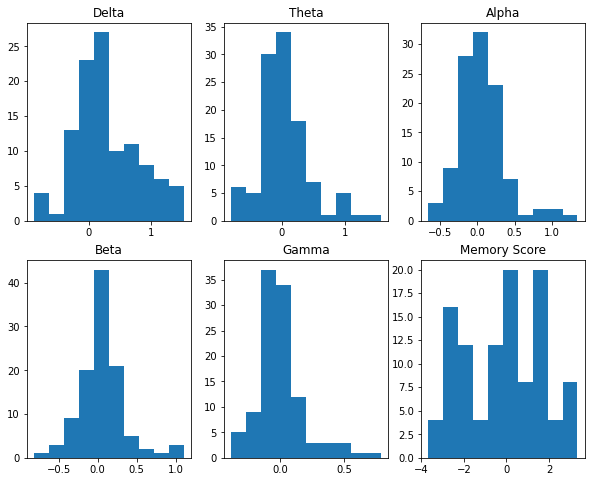

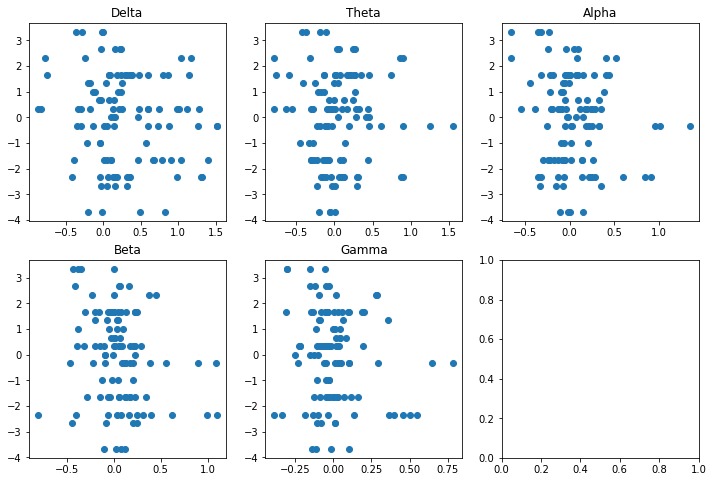

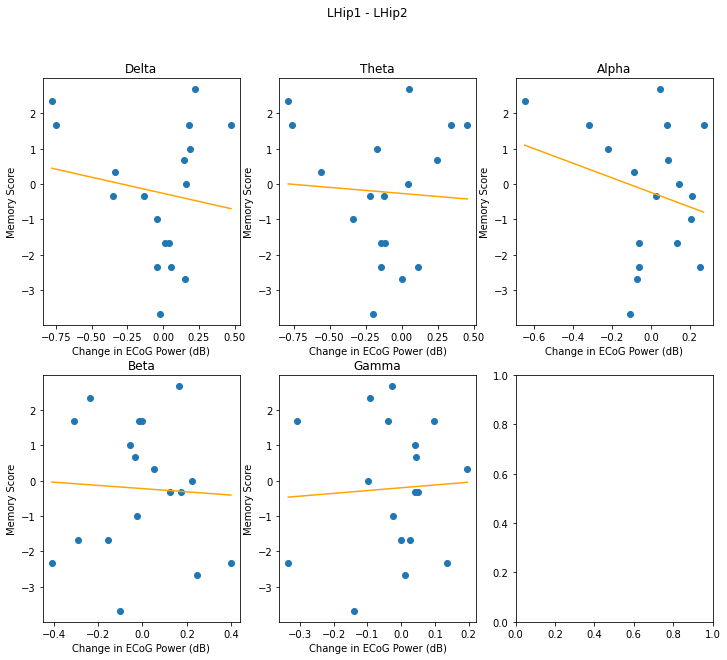

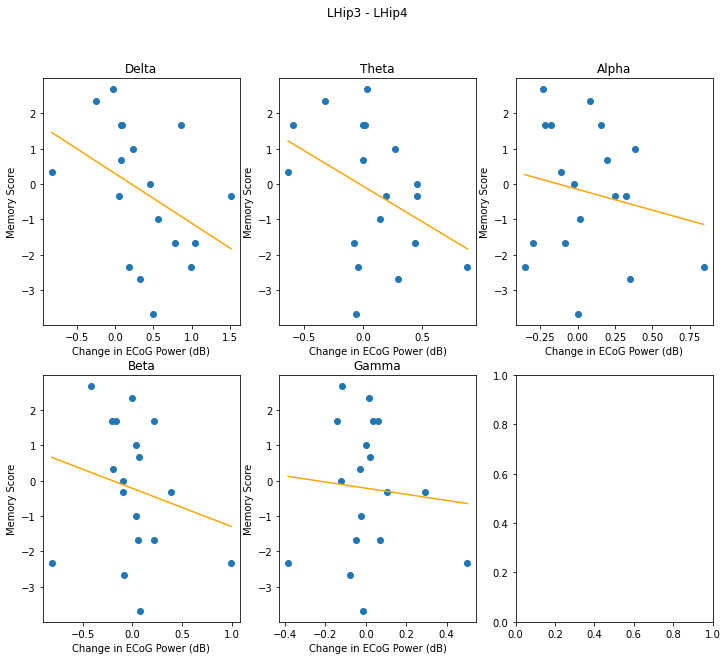

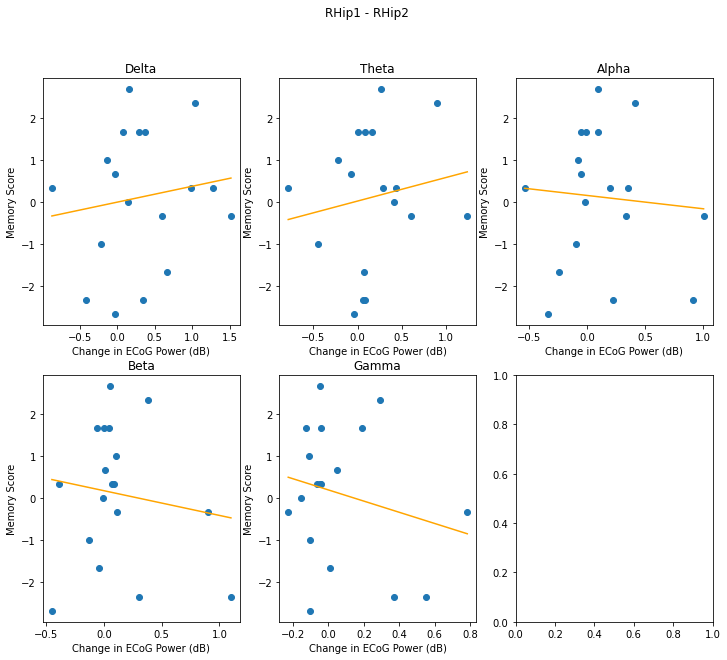

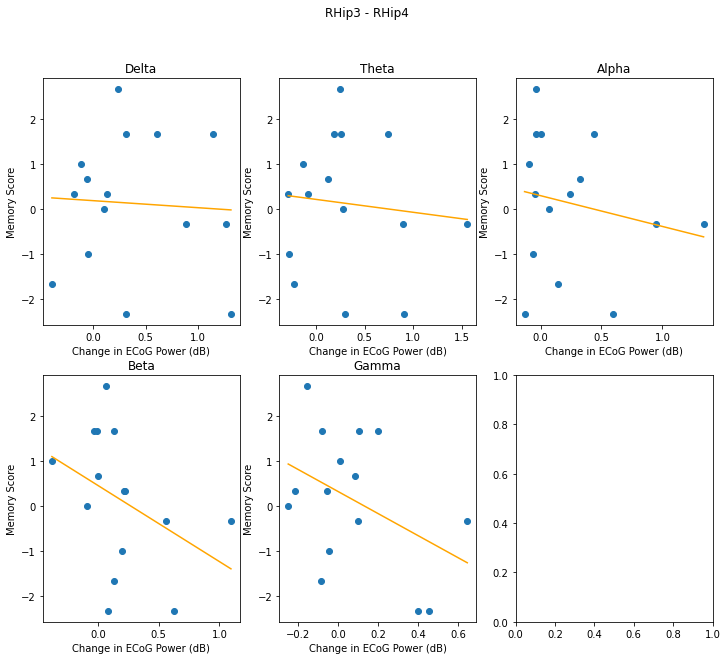

In [67]:
do_stats(power_and_mem, '$FREQ_log_chg', 'Memory_Score - Avg_Sham', 'Change in ECoG Power (dB)', 'Memory Score')

## Trial Memory Chg vs Power Pre (averaged)

Averaging across stims in the same patient, channel, and trial


Channel Frequency         r         P
0   LHip1 - LHip2     Delta -0.098956  0.696053
1   LHip1 - LHip2     Theta -0.157925  0.531403
2   LHip1 - LHip2     Alpha -0.046598  0.854325
3   LHip1 - LHip2      Beta  0.031576  0.901017
4   LHip1 - LHip2     Gamma  0.019294  0.939430
5   LHip3 - LHip4     Delta -0.245104  0.326940
6   LHip3 - LHip4     Theta -0.223865  0.371855
7   LHip3 - LHip4     Alpha -0.207231  0.409315
8   LHip3 - LHip4      Beta -0.182384  0.468853
9   LHip3 - LHip4     Gamma -0.270300  0.278005
10  RHip1 - RHip2     Delta -0.044637  0.860395
11  RHip1 - RHip2     Theta  0.030235  0.905201
12  RHip1 - RHip2     Alpha  0.189951  0.450278
13  RHip1 - RHip2      Beta  0.368982  0.131853
14  RHip1 - RHip2     Gamma  0.647684  0.003658
15  RHip3 - RHip4     Delta -0.110626  0.694695
16  RHip3 - RHip4     Theta -0.028925  0.918498
17  RHip3 - RHip4     Alpha  0.059718  0.832567
18  RHip3 - RHip4      Beta  0.192667  0.491483
19  RHip3 - RHip4     Gamma  0.576388  0.024508

Linear regression:


Frequency      Delta  Theta  Alpha  Beta  Gamma
Channel                                        
LHip1 - LHip2    NaN    NaN    NaN   NaN    NaN
LHip3 - LHip4    NaN    NaN    NaN   NaN    NaN
RHip1 - RHip2    NaN    NaN    NaN   NaN    NaN
RHip3 - RHip4    NaN    NaN    NaN   NaN    NaN

Fisher Exact:


Frequency      Delta  Theta  Alpha  Beta  Gamma
Channel                                        
LHip1 - LHip2    NaN    NaN    NaN   NaN    NaN
LHip3 - LHip4    NaN    NaN    NaN   NaN    NaN
RHip1 - RHip2    NaN    NaN    NaN   NaN    NaN
RHip3 - RHip4    NaN    NaN    NaN   NaN    NaN

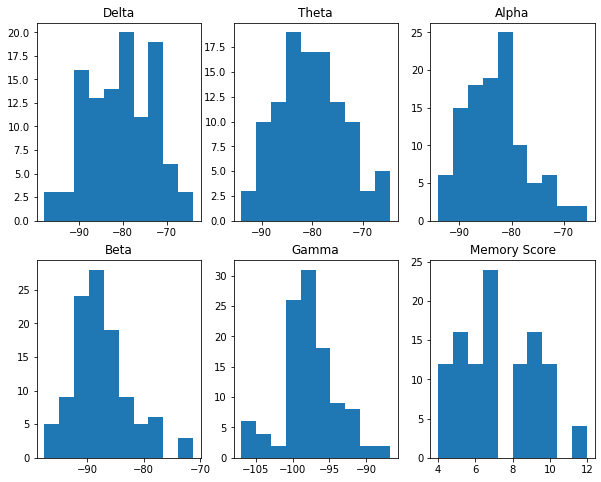

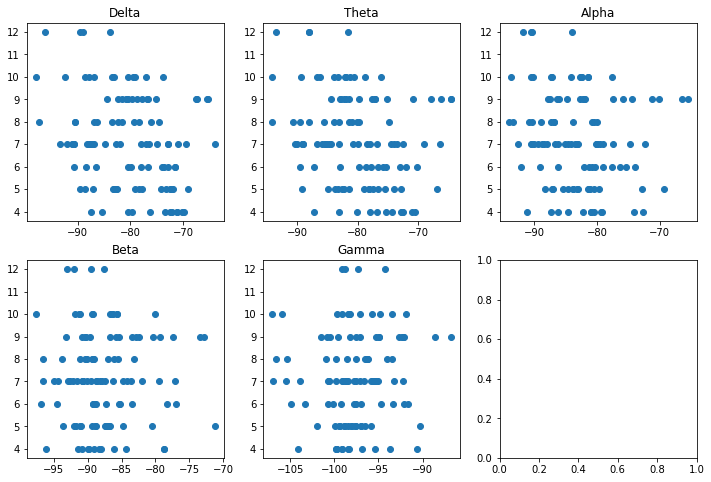

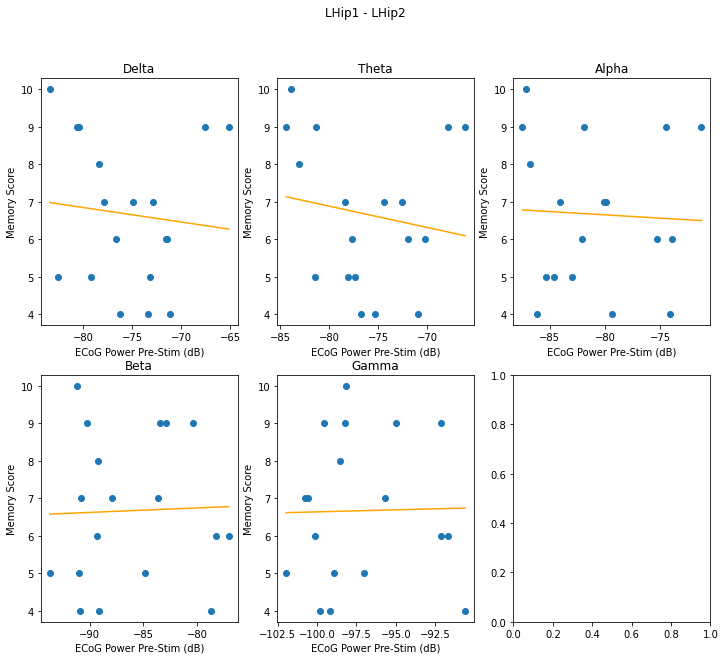

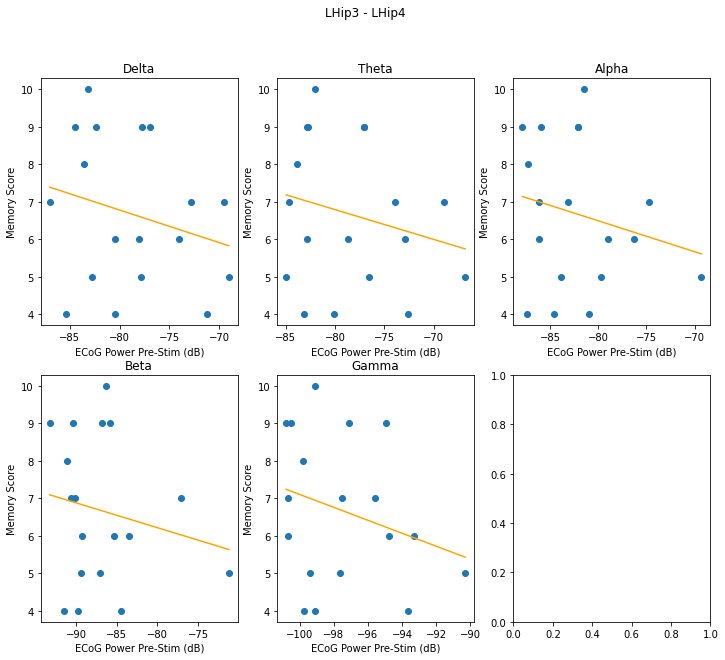

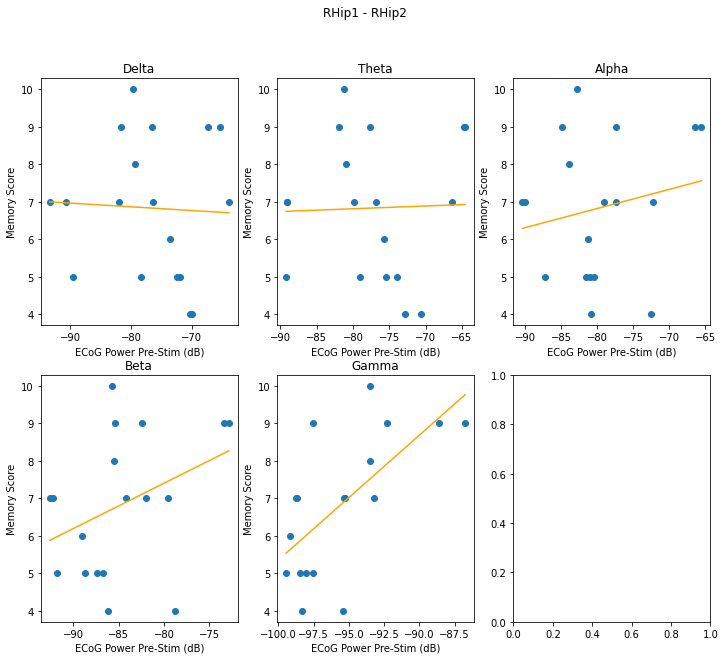

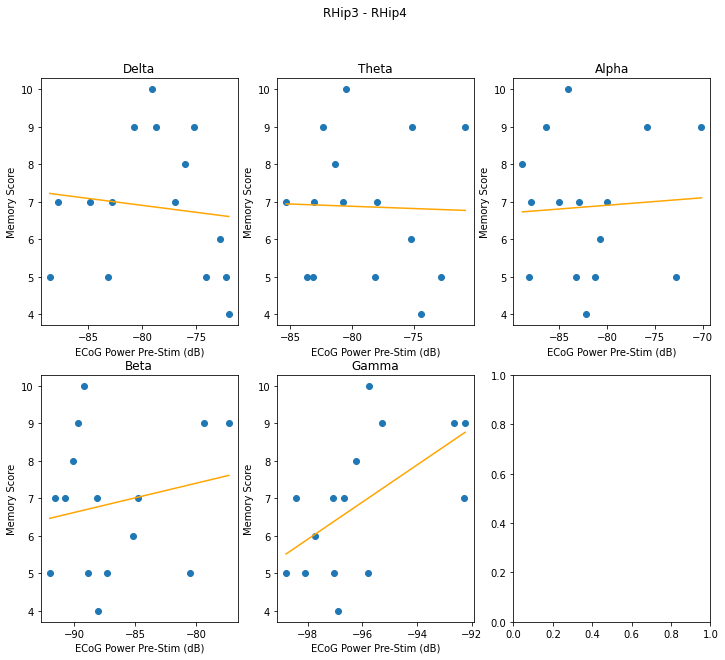

In [68]:
do_stats(power_and_mem, '10 * log($FREQ_pre) / log(10)', 'Memory_Score', 'ECoG Power Pre-Stim (dB)', 'Memory Score')

## Delay Memory Chg vs Power Change (averaged)

AttributeError: 'str' object has no attribute 'eval'

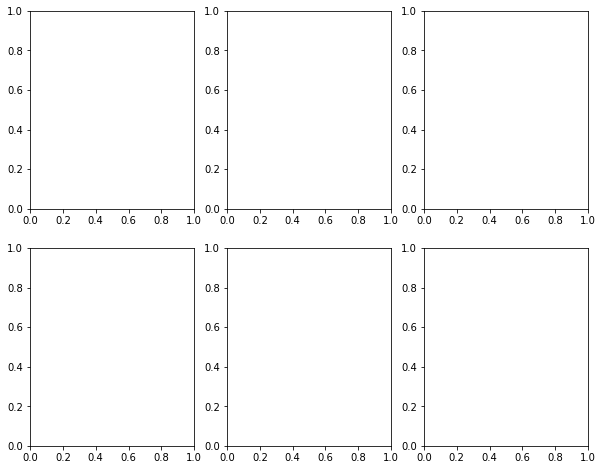

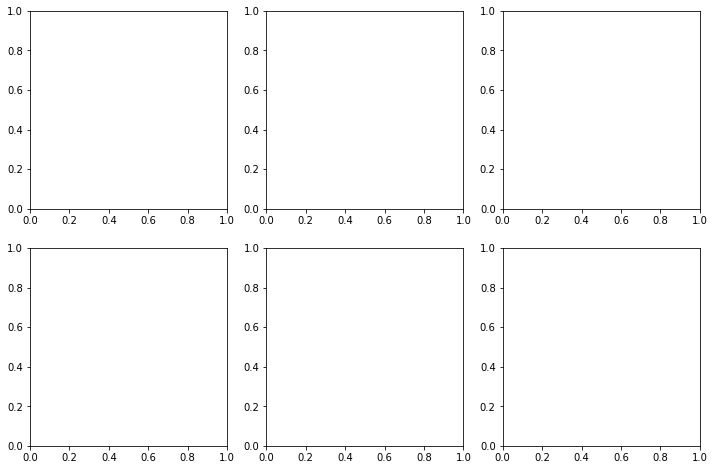

In [69]:
do_stats('$FREQ_log_chg', 'Delay_Mem_Stim - Delay_Mem_Sham', 'Average Change in ECoG Power (dB)', 'Change in Delay Memory')

# Sanity Checks

In [ ]:
power_and_mem[power_and_mem['ID'] == 109]['Channel'].unique()

array(['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip1 - RHip3'],
      dtype=object)

In [ ]:
power_and_mem[power_and_mem['ID'] == 106]['Channel'].unique()

array(['LPS1 - LPS2', 'LPS3 - LPS4', 'LPIH4 - LPIH1', 'LPIH4 - LPIH3'],
      dtype=object)

In [ ]:
(memory_delayed['Delay_Mem_Stim'] - memory_delayed['Delay_Mem_Sham']).mean()

2.4761904761904763

In [ ]:
mem_delay_any_stim = memory_delayed[memory_delayed['ID'].isin(power_log_chg['ID'].unique())]
(mem_delay_any_stim['Delay_Mem_Stim'] - mem_delay_any_stim['Delay_Mem_Sham']).mean()

0.9

# TODO
- John: average power for each trial on the x, plot trial memory on Y
- Haneef: 3-word groups, each stim would have own mem score
- sham recording power vs sham memory scores
    - does stimulation make that better or worse?
- mean change from sham to stim is zero for current 6-7 patients
    - change from short-term to delay instead of change from sham to stim
    - consider patient-level + 3-word group level for both


- currently looking at effect of stimulation
- need to confirm increase in delta not due to post-stim artifact
- zoom into box plot to compare medians
- look at power shifts instead of just amplitude-time
- permutation test for specific channels
- FDR corrections
- correlations between the power and memory
- FUTURE: look at amplitude changes across stim 1 vs 2 vs 3 vs 4
- FUTURE: phase-amplitude coupling
- FUTURE: coherence analysis
- FUTURE: spectrograms
- FUTURE: associate with memory changes

In [ ]:
pts_w_any_stim

[100, 103, 105, 106, 109, 110, 111, 112, 113, 115]

In [ ]:
pt_w_stim_not_111 = pts_w_any_stim[:6] + pts_w_any_stim[7:]
check_trials = memory_trials.loc[pt_w_stim_not_111,:]

In [ ]:
scipy.stats.ttest_rel(check_trials['Memory_Score'], check_trials['Avg_Sham'])

Ttest_relResult(statistic=-0.1064608583282014, pvalue=0.9160338975709146)

In [ ]:
check_stim = memory_delayed[memory_delayed['ID'].isin(pts_w_any_stim)]
# check_stim = check_stim[check_stim['ID'] != 111]
check_stim

ID  Delay_Mem_Stim  Delay_Mem_Sham
0   100             4.0               5
3   103            10.0               8
5   105             3.0               3
6   106            12.0              11
9   109             6.0               6
10  110             5.0               4
11  111             8.0               0
12  112             9.0              10
13  113             8.0               8
14  115             4.0               5

In [ ]:
scipy.stats.ttest_rel(check_stim['Delay_Mem_Stim'], check_stim['Delay_Mem_Sham'])

Ttest_relResult(statistic=1.0598427071714605, pvalue=0.31682960824765083)

In [ ]:
memory_delayed

ID  Delay_Mem_Stim  Delay_Mem_Sham
0   100             4.0               5
1   101             4.0               4
2   102             7.0               8
3   103            10.0               8
4   104             3.0               0
5   105             3.0               3
6   106            12.0              11
7   107            10.0               0
8   108             6.0               5
9   109             6.0               6
10  110             5.0               4
11  111             8.0               0
12  112             9.0              10
13  113             8.0               8
14  115             4.0               5
15  200             4.0               1
16  201             NaN               7
17  202             5.0               2
18  205             NaN               0
19  206             6.0               3
20  207             9.0               0
21  208             8.0               0
22  209             4.0               0